CPU or GPU? :  cpu(0)
(1249, 8192)
Peak sampling point at 7371th (0.90s).
总波形数目： (1249,)
训练集波形数目： 600
测试集波形数目： 649


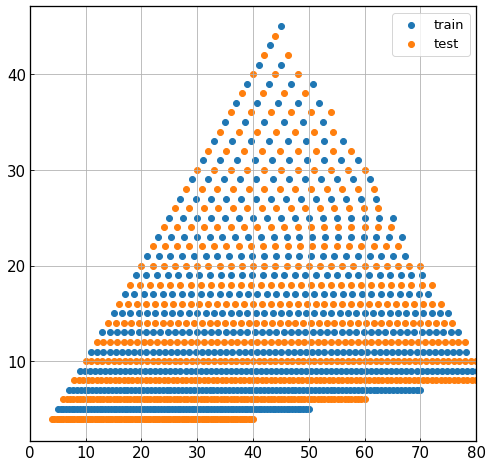

In [1]:
import sys, os
sys.path.append(os.path.abspath(''))   # 把当前目录设为引用模块的地址之一

from utils import *
from data_utils import *
from models.solver_cnn import *
from models.ConvNet import *

from data_utils import *
from data_noise import *

import mxnet as mx
import mxnet.ndarray as nd

import numpy as np
import pandas as pd
from itertools import product, permutations

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

plt.rcParams['axes.linewidth'] = 1.3
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['axes.labelsize'] = 15
plt.rcParams['legend.fontsize'] = 13

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

# Easily Profile Python Code in Jupyter
# install conda install line_profiler or pip install line-profiler
# see http://mortada.net/easily-profile-python-code-in-jupyter.html
%load_ext line_profiler

test_ctx()

#############################
GW_address = './data/'

data = pd.DataFrame(np.load(GW_address+'GW_H1.npy'), index=np.load(GW_address+'GW_H1_index.npy'))
print(data.shape)
peak_samppoint = data.values.argmax(axis=1)
peak_samppoint = int(peak_samppoint.sum() / peak_samppoint.shape[0])
peak_time = peak_samppoint/data.shape[-1]
peak_time = float('{:.2f}'.format(peak_time))
print('Peak sampling point at %dth (%.2fs).' %(peak_samppoint, peak_time))
data.head()
# 波形数据


print('总波形数目：', data.index.shape)
train_masses = [(float(masses.split('|')[0]), float(masses.split('|')[1])) for masses in data.index if float(masses.split('|')[0]) % 2 != 0]
test_masses = [(float(masses.split('|')[0]), float(masses.split('|')[1])) for masses in data.index if float(masses.split('|')[0]) % 2 == 0]
print('训练集波形数目：', len(train_masses))
print('测试集波形数目：', len(test_masses))

train_m1, train_m2 = [ m[0] for m in train_masses],  [ m[1] for m in train_masses]
test_m1, test_m2 = [ m[0] for m in test_masses],  [ m[1] for m in test_masses]
plt.figure(figsize= (8,8))
plt.scatter(train_m2, train_m1, label='train')
plt.scatter(test_m2, test_m1, label = 'test')
plt.grid()
plt.legend()
plt.xlim(0,80)
# plt.title('训练集和测试集的波形在质量上的分布')
plt.show()

# 做好训练集和测试集的分割~

test_masses = [masses for masses in data.index if float(masses.split('|')[0]) % 2 == 0]
train_masses = [masses for masses in data.index if float(masses.split('|')[0]) % 2 != 0]
train_data = data.loc[train_masses]
test_data = data.loc[test_masses]

In [ ]:
def ppp(data, fLow, fHigh, fs, shuffle = True):

    if shuffle:
        data, shift_list = shuffle_data_nd(nd.array(data, ctx=mx.cpu()),peak_samppoint, peak_time, 5)
        data = pd.DataFrame(data.asnumpy())

    b = nd.array(pre_fir(fLow=fLow, fHigh=fHigh, fs = fs).reshape((-1,1)), ctx=ctx)
    pp = pre_fftfilt(b, shape = data.shape, nfft=None)
    vline_list = []
    mf_list = []
    for snr in (np.array([0.01]+np.arange(0.05,1.04,0.05).tolist())):
        n = GenNoise_matlab_nd(shape = data.shape, params=pp)
        sigma_ = data.max(axis=1) / float(snr) / n.asnumpy().std(axis=1 , dtype = 'float64')
        signal_ = data.div(sigma_, axis=0)
        sim = signal_ + n.asnumpy()
        mf = SNR_MF(sim, n.asnumpy(), signal_)
#         print(mf.mean())
        plt.hist(mf , bins = 50, alpha = 0.6)
        plt.vlines(x = np.array(mf).mean(), ymin=0, ymax=90, alpha = 0.8)
        mf_list.append(mf)
        vline_list.append(np.array(mf).mean())
        print(snr)
    plt.show()
    print(vline_list)
    return mf_list

In [408]:
random_peak = np.concatenate((Normolise(data).values[300][600:], np.array([0,]*600)) ,)

(8192,)

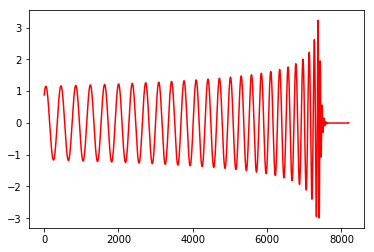

In [492]:
# plt.figure(figsize=(20,10))
random_peak = np.concatenate((Normolise(data).values[600][1:], np.array([0,]*1)) ,)
# plt.plot(Normolise(data).values[100], 'r')
plt.plot(random_peak, 'r')
plt.savefig('./images/waveform_dataflow0.png',dpi=300, bbox_inches='tight',transparent=False)

/Users/Herb/github/Python4GW/data_noise.py:204: ComplexWarning: Casting complex values to real discards the imaginary part
  y[istart-1:yend,:] = y[istart-1:yend,:] + Y[:(yend-istart+1),:]


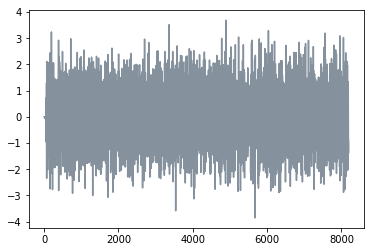

In [494]:
# plt.figure(figsize=(20,10))
noise = Normolise([GenNoise_matlab(nDataSamples=8192)])[0]
# plt.plot(noise)
# plt.plot(noise+ Normolise(data).values[300]/Normolise(data).values[300].max(),alpha=0.6, color='#34495e')
# plt.plot(Normolise(data).values[300]/Normolise(data).values[300].max(), 'r')
plt.plot(noise,alpha=0.6, color='#34495e')
# plt.plot(noise+ random_peak/random_peak.max(),alpha=0.6, color='#34495e')
# plt.plot(random_peak/random_peak.max(), 'r')
plt.savefig('./images/noise_dataflow1.png', dpi=300, bbox_inches='tight',transparent=False)

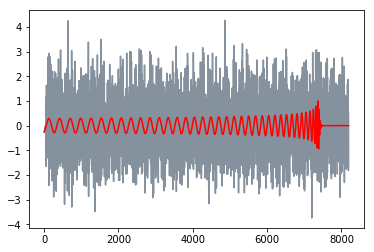

In [435]:
plt.plot(noise+ random_peak/random_peak.max(),alpha=0.6, color='#34495e')
plt.plot(random_peak/random_peak.max(), 'r')

In [463]:
def Fine_tune(name, value):
    default = {'default':{'drop_prob': 0,
                          'fc_params_act_type': ({'hidden_dim':(64,)},
                                                 {'act_type': ('relu',)*4}),
                          'pool_type_kernel': (('avg','avg','avg',), 
                                               ((1,16), (1,16), (1,16),)),
                          'dialute': 1,
                          'num_filter': (16,32,64) }}
    df = pd.DataFrame(default)
    df.drop([name], inplace=True)
    params_list = []
    for i,j in product(value, dict(df).values()):
        dd = dict(j)
        dd[name] = i
        dd['hidden_dim'] = dd['fc_params_act_type'][0]
        dd['act_type'] = dd.pop('fc_params_act_type')[1]
        dd['pool_type'] = dd['pool_type_kernel'][0]
        dd['pool_kernel'] = dd.pop('pool_type_kernel')[1]        
        params_list.append(dd)
    return params_list
def test(diedai):
    for hyperparam in diedai:
        hidden_dim = hyperparam['hidden_dim']
        drop_prob = hyperparam['drop_prob']
        num_filter = hyperparam['num_filter']
        act_type= hyperparam['act_type']
        dialute= hyperparam['dialute']
        pool_kernel = hyperparam['pool_kernel']
        pool_type = hyperparam['pool_type']
        print()
        print('hidden_dim |', hidden_dim)
        print('drop_prob |' , drop_prob)
        print('num_filter |', num_filter)
        print('act_type |' , act_type)
        print('dialute |', dialute)
        print('pool_kernel |', pool_kernel)
        print('pool_type |', pool_type)

In [470]:
for j,i in zip(['1','3'], Fine_tune('fc_params_act_type', [({'hidden_dim': (64,)}, {'act_type': ('elu',)*4}),
                                          ({'hidden_dim': (64,)}, {'act_type': ('relu',)*4})]) ):
    print(j,i)

1 {'dialute': 1, 'drop_prob': 0, 'num_filter': (16, 32, 64), 'hidden_dim': {'hidden_dim': (64,)}, 'act_type': {'act_type': ('elu', 'elu', 'elu', 'elu')}, 'pool_type': ('avg', 'avg', 'avg'), 'pool_kernel': ((1, 16), (1, 16), (1, 16))}
3 {'dialute': 1, 'drop_prob': 0, 'num_filter': (16, 32, 64), 'hidden_dim': {'hidden_dim': (64,)}, 'act_type': {'act_type': ('relu', 'relu', 'relu', 'relu')}, 'pool_type': ('avg', 'avg', 'avg'), 'pool_kernel': ((1, 16), (1, 16), (1, 16))}


In [503]:
!mv /Users/Herb/Downloads/eta\=-0.1 /Users/Herb/Downloads/eta_m0_1.csv

In [527]:
!mv /Users/Herb/Downloads/eta\=3 /Users/Herb/Downloads/eta_3.csv

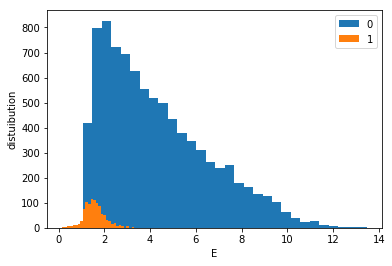

In [540]:
import matplotlib.pyplot as plt
import seaborn as sns

file_address = '/Users/Herb/Downloads/eta_3.csv'
df = pd.read_csv(file_address, header=1,delim_whitespace=True)
plt.hist(df[df.m == 0].E, bins=30, label = '0')
plt.hist(df[df.m == 1].E, bins=30, label= '1')
plt.xlabel('E')
plt.ylabel('distuibution')
plt.legend()

## Statistics of $\rho_{MF}$ for fixed $\rho_{amp}$. 

In each color, we fix a given $\rho_{amp}$, which is shown in the legend, and generate randomly data d = n + h, in which 5-fold expansion for h by peak-location randomization. For each simulated data we compute the corresponding $\rho_{MF}$ and count the numbers for each $\rho_{MF}$ range.

Save or not? (y/n)y
Saved in ./images/distributionsnr_mf_vs_snr_amp.pdf


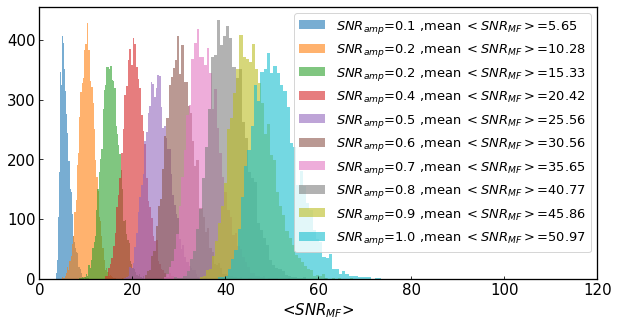

In [3]:
# snr_mf = ppp(data=data, fLow=9, fHigh=9000, fs = 8192)
# np.save('./images/data/snr_mf_5fold', snr_mf)
snr_mf = np.load('./images/data/snr_mf_5fold.npy')

plt.figure(figsize=(10,5))
for i, snr in enumerate(np.array([0.01]+np.arange(0.05,1.04,0.05).tolist())[1::2]):
    plt.hist(snr_mf[i*2+2] , bins = 50, alpha = 0.6, label = '$SNR_{amp}$=%.1f ,mean $<SNR_{MF}>$=%.2f' %(snr, np.array(snr_mf[i*2+2]).mean()))
plt.xlabel('<$SNR_{MF}$>')
plt.legend(loc='upper right')
plt.xlim(xmax=120)
if input('Save or not? (y/n)') == 'y':
    save_address = './images/'
    plt.savefig(save_address + 'distribution_snr_mf_vs_snr_amp.pdf', dpi = 300, bbox_inches = 'tight')
    print('Saved in '+save_address+'distributionsnr_mf_vs_snr_amp.pdf')
else:
    pass
plt.show()

## SNR $\langle\rho_{MP}\rangle$ v.s $\rho_{amp}$

Relation between the averaged matched filtering SNR $\langle\rho_{MP}\rangle$ and $\rho_{amp}$ based on the statistics investigation (above Fig). Approximated linear relation is also shown in the plot.

Save or not? (y/n)y
Saved in ./images/snr_mf_vs_snr_amp.eps


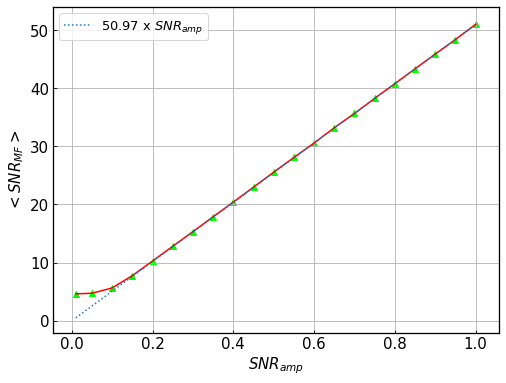

In [4]:
plt.figure(figsize=(8,6))
x = np.array([0.01]+np.arange(0.05,1.04,0.05).tolist())

snr_mf = np.load('./images/data/snr_mf_5fold.npy')
snr_mf_mean = snr_mf.mean(axis=1)

plt.plot(x, snr_mf_mean, 'r-')
plt.plot(x, x*snr_mf_mean[-1], ls='dotted', label = '%.2f x $SNR_{amp}$' %snr_mf_mean[-1])
plt.scatter(np.array([0.01]+np.arange(0.05,1.04,0.05).tolist()), snr_mf_mean,marker='^', c='lime')
plt.xlabel('$SNR_{amp}$')
plt.ylabel('$<SNR_{MF}>$')
plt.legend()
plt.grid()
if input('Save or not? (y/n)') == 'y':
    save_address = './images/'
    plt.savefig(save_address + 'snr_mf_vs_snr_amp.eps', dpi = 300, bbox_inches = 'tight')
    print('Saved in '+save_address+'snr_mf_vs_snr_amp.eps')
else:
    pass
plt.show()

## ROC comparison among different $\rho_{MF}$ of training data

Automatically created module for IPython interactive environment
Save or not? (y/n)y
Saved in ./images/ROC_comparison_training.eps


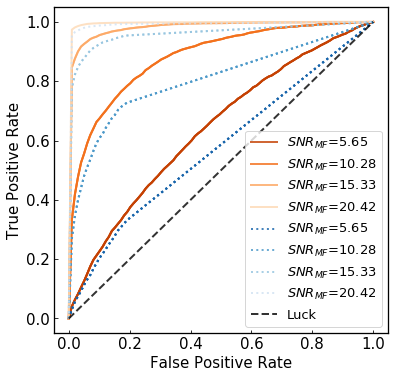

In [5]:
# https://stackoverflow.com/questions/41806066/families-of-curves-with-different-seaborn-palettes-in-one-plot
print(__doc__)
tpr_OURs_new2 = np.load('./AUC_data/tpr_OURs_new2.npy')
fpr_OURs_new2 = np.load('./AUC_data/fpr_OURs_new2.npy')

tpr_OURs_2localnoise10 = np.load('./AUC_data/tpr_OURs_2localnoise10.npy')
fpr_OURs_2localnoise10 = np.load('./AUC_data/fpr_OURs_2localnoise10.npy')

snr_mf = np.load('./images/data/snr_mf_5fold.npy')
snr_mf_mean = snr_mf.mean(axis=1)

from scipy import interp
mean_fpr = np.linspace(0, 1, 100)
snr_training = 0
snr_testings = 4


# plt.figure(figsize=(10,10))
fig, ax = plt.subplots()
fig.set_figheight(6)
fig.set_figwidth(6)
mean_tpr_list = []
index_list = []
for snr_testing in range(0,snr_testings):
    tprs = []
    for i in range(5):
        tprs.append(interp(mean_fpr, 
                           fpr_OURs_new2[snr_training,snr_testing][i], 
                           tpr_OURs_new2[snr_training,snr_testing][i]).tolist())
        tprs[-1][0] = 0.0
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_tpr_list.append(mean_tpr.tolist())
    index_list.append('%s' %['$SNR_{MF}$=%.2f' %snr for snr in snr_mf_mean[2::2]][snr_testing])
#     plt.plot(mean_fpr, mean_tpr, lw=2, alpha=.8,
#              label = '%s' %['$SNR_{MF}$=%.2f' %snr for snr in snr_mf_mean[2::2]][snr_testing])
    df = pd.DataFrame(mean_tpr_list, index = index_list)
    df.T.plot(x=mean_fpr, ax=ax, color=sns.color_palette('Oranges_r', snr_testings), lw=2, alpha=.8)
    
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
#     ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2)

mean_tpr_list = []
index_list = []    
for snr_testing in range(0,snr_testings):
    tprs = []
    for i in range(5):
        tprs.append(interp(mean_fpr, 
                           fpr_OURs_2localnoise10[snr_training,snr_testing][i], 
                           tpr_OURs_2localnoise10[snr_training,snr_testing][i]).tolist())
        tprs[-1][0] = 0.0
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_tpr_list.append(mean_tpr.tolist())
    index_list.append('%s' %['$SNR_{MF}$=%.2f' %snr for snr in snr_mf_mean[2::2]][snr_testing])
#     plt.plot(mean_fpr, mean_tpr, lw=2, alpha=.8,
#              label = '%s' %['$SNR_{MF}$=%.2f' %snr for snr in snr_mf_mean[2::2]][snr_testing])
    df = pd.DataFrame(mean_tpr_list, index = index_list)
    df.T.plot(x=mean_fpr, ax=ax, color=sns.color_palette('Blues_r', snr_testings),linestyle=':' ,lw=2, alpha=.8)  

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
#     ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2)
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k',
         label='Luck', alpha=.8)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# plt.title('Receiver operating characteristic example')
plt.legend(ncol = 1, loc="lower right")

if input('Save or not? (y/n)') == 'y':
    save_address = './images/'
    plt.savefig(save_address + 'ROC_comparison_training.eps', dpi = 300, bbox_inches = 'tight')
    plt.savefig(save_address + 'ROC_comparison_training.pdf', dpi = 300, bbox_inches = 'tight')
    print('Saved in '+save_address+'ROC_comparison_training.eps')
else:
    pass

plt.show()

## AUC comparison among different $\rho_{MF}$ of training data

In [6]:
# AUC_PRL = np.load('./AUC_data/AUC_PRL_new2.npy')
# AUC_PLB = np.load('./AUC_data/AUC_PLB_new2.npy')
AUC_OURs = np.load('./AUC_data/AUC_OURs_new2.npy')
# AUC_OURs_2localnoise1 = np.load('./AUC_data/AUC_OURs_2localnoise1.npy')
# AUC_OURs_2localnoise5 = np.load('./AUC_data/AUC_OURs_2localnoise5.npy')
AUC_OURs_2localnoise10 = np.load('./AUC_data/AUC_OURs_2localnoise10.npy')
# AUC_OURs_new3_localnoise = np.load('./AUC_data/AUC_OURs_new3_localnoise.npy')

Save or not? (y/n)y
Saved in ./images/AUC_comparison_training.eps


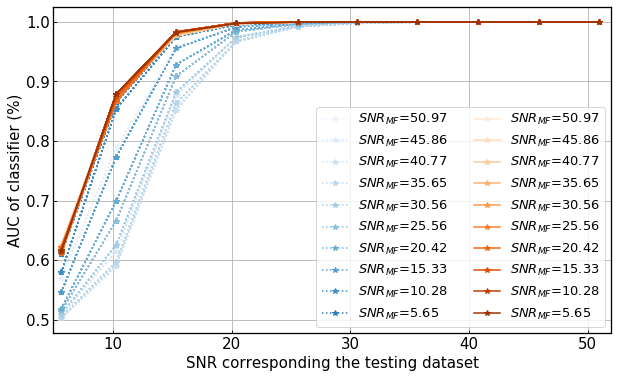

In [7]:
# https://stackoverflow.com/questions/41806066/families-of-curves-with-different-seaborn-palettes-in-one-plot
snr_mf = np.load('./images/data/snr_mf_5fold.npy')
snr_mf_mean = snr_mf.mean(axis=1)

fig, ax = plt.subplots()
fig.set_figheight(6)
fig.set_figwidth(10)
df = pd.DataFrame(AUC_OURs_2localnoise10.min(axis=2), index = ['$SNR_{MF}$=%.2f' %snr for snr in snr_mf_mean[2::2]][::-1], 
                  columns=snr_mf_mean[2::2])
for i in range(AUC_OURs_2localnoise10.shape[0]):
    df.T.plot(marker= '*',linestyle=':', ax=ax, color=sns.color_palette('Blues', 13), alpha = 1)    

df = pd.DataFrame(AUC_OURs.min(axis=2), index = ['$SNR_{MF}$=%.2f' %snr for snr in snr_mf_mean[2::2]][::-1], 
                  columns=snr_mf_mean[2::2])    
for i in range(AUC_OURs.shape[0]):
    df.T.plot(marker= '*', ax=ax, color=sns.color_palette("Oranges", 10), alpha = 1)    
ax.legend(ncol=2, loc='best')
ax.set_xlim(5, 52)
ax.set_ylabel('AUC of classifier (%)')
ax.set_xlabel('SNR corresponding the testing dataset')
ax.grid()
if input('Save or not? (y/n)') == 'y':
    save_address = './images/'
    plt.savefig(save_address + 'AUC_comparison_training.eps', dpi = 300, bbox_inches = 'tight')
    plt.savefig(save_address + 'AUC_comparison_training.pdf', dpi = 300, bbox_inches = 'tight')
    print('Saved in '+save_address+'AUC_comparison_training.eps')
else:
    pass
plt.show()

## Asymptotical accuracy of signal recognizing 

The relation between the asymptotical accuracy of signal recognizing and the SNR $\rho_{MF}$ of the training / testing data.


In [8]:
acc_training_list =  []
acc_testing_list =  []

acc_training_list_finitenoise =  []
acc_testing_list_finitenoise =  []
for i in range(1,11):
    os.system('ls -a ./pretrained_models/OURs_new/snr_%s_best* > test.txt' %(i*10))
    params_adds = pd.read_csv('./test.txt', header=None)
    os.system('rm test.txt')
    where_stop = params_adds[0].map(lambda x: int(x.split('_')[6].split('@')[1]))
    acc_training_list.append(nd.load('./pretrained_models/OURs_new/snr_%s_info.pkl' %(i*10))['train_acc_history'].asnumpy()[where_stop-1][0].tolist())
    acc_testing_list.append(nd.load('./pretrained_models/OURs_new/snr_%s_info.pkl' %(i*10))['test_acc_history'].asnumpy()[where_stop-1][0].tolist())
    
    os.system('ls -a ./pretrained_models/OURs_2finitenoise10/snr_%s_best* > test.txt' %(i*10))
    params_adds = pd.read_csv('./test.txt', header=None)
    os.system('rm test.txt')
    where_stop = params_adds[0].map(lambda x: int(x.split('_')[6].split('@')[1]))
    acc_training_list_finitenoise.append(nd.load('./pretrained_models/OURs_2finitenoise10/snr_%s_info.pkl' %(i*10))['train_acc_history'].asnumpy()[where_stop-1][0].tolist())
    acc_testing_list_finitenoise.append(nd.load('./pretrained_models/OURs_2finitenoise10/snr_%s_info.pkl' %(i*10))['test_acc_history'].asnumpy()[where_stop-1][0].tolist())

Save or not? (y/n)y
Saved in ./images/asymptotical_acc.eps


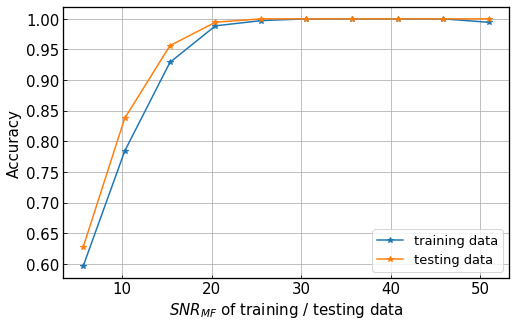

In [9]:
snr_mf = np.load('./images/data/snr_mf_5fold.npy')
snr_mf_mean = snr_mf.mean(axis=1)

plt.figure(figsize=(8,5))
plt.plot(snr_mf_mean[2::2], acc_training_list, '*-', label = 'training data')
plt.plot(snr_mf_mean[2::2], acc_testing_list, '*-', label = 'testing data')
plt.xlabel('$SNR_{MF}$ of training / testing data')
plt.ylabel('Accuracy')
plt.grid()
plt.legend(loc='lower right')

if input('Save or not? (y/n)') == 'y':
    save_address = './images/'
    plt.savefig(save_address + 'asymptotical_acc.eps', dpi = 300, bbox_inches = 'tight')
    plt.savefig(save_address + 'asymptotical_acc.pdf', dpi = 300, bbox_inches = 'tight')
    print('Saved in '+save_address+'asymptotical_acc.eps')
else:
    pass

plt.show()


# plt.plot(acc_training_list_finitenoise, label = 'train_local')
# plt.plot(acc_testing_list_finitenoise, label = 'test_local')
# plt.legend()


## Fine-tune number of MLP layers

[1.0, 1.0, 0.99999888581363738, 0.99993658968789501, 0.99973374222953315, 0.99905631692109154, 0.99693547410333772, 0.99044763245447498, 0.97003151093807682, 0.91317210670706983, 0.79970640424708617, 0.65893888124154099, 0.5573468607646308, 0.52439170230897869]


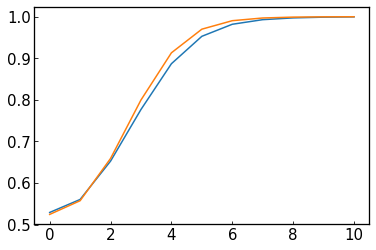

In [42]:
(AUC_OURs['100'])
print(AUC_OURs['%s' %int(0.1*100)])
plt.plot(AUC_num_MLP2['%s' %int(0.1*100)][::-1])
plt.plot(AUC_OURs['%s' %int(0.1*100)][3:][::-1])


0.1
Save or not? (y/n)y
Saved in ./images/fine_tune_oldnewNoise_num_MLPlayers.eps


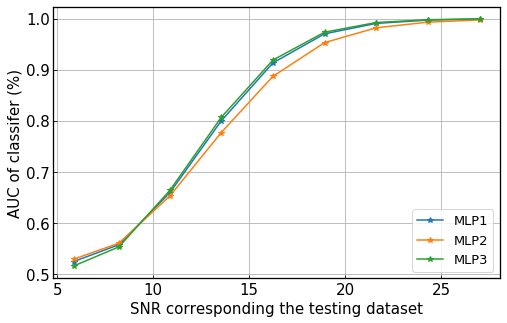

MLP1


In [44]:
AUC_num_MLP2 = np.load('./AUC_data/AUC_OURs_old_newNoise_num_MLP2MLP.npy').tolist()
AUC_num_MLP3 = np.load('./AUC_data/AUC_OURs_old_newNoise_num_MLP3MLP.npy').tolist()
AUC_OURs = np.load('./AUC_data/AUC_OURs_old_newNoise_newSNRlist.npy').tolist()

SNR_list = [1, 0.8, 0.6, 0.5, 0.45, 0.4, 0.35, 0.3, 0.25,0.2, 0.15, 0.1, 0.05, 0.01][3:-2]
SNR_MF_list = [53.97, 43.18, 32.39, 26.99, 24.30, 21.60, 18.92, 16.23, 13.54, 10.86, 8.21, 5.86, 4.77, 4.64][3:-2]
index = ['SNR=%.2f' %snr for snr in SNR_MF_list]

# SNR_test_list =[(16*2**i,) for i in range(4+1)[::-1]] 
plt.figure(figsize=(8,5))
for i, SNR_ in enumerate(SNR_list[::-1]):
#     with sns.color_palette("Set1_r",len(SNR_list)):
    print(SNR_)
    plt.plot(SNR_MF_list[::-1], AUC_OURs['%s' %int(SNR_*100)][3:][::-1][:-2], '*-',label = 'MLP1')
    plt.plot(SNR_MF_list[::-1], AUC_num_MLP2['%s' %int(SNR_*100)][::-1][:-2], '*-',label = 'MLP2')
    plt.plot(SNR_MF_list[::-1], AUC_num_MLP3['%s' %int(SNR_*100)][::-1][:-2], '*-',label = 'MLP3')
    break

plt.legend(loc='lower right')
plt.xlabel('SNR corresponding the testing dataset')
plt.ylabel('AUC of classifer (%)')
plt.grid()
if input('Save or not? (y/n)') == 'y':
    save_address = './images/'
    plt.savefig(save_address + 'fine_tune_oldnewNoise_num_MLPlayers.eps', dpi = 300, bbox_inches = 'tight')
    plt.savefig(save_address + 'fine_tune_oldnewNoise_num_MLPlayers.pdf', dpi = 300, bbox_inches = 'tight')
    print('Saved in '+save_address+'fine_tune_oldnewNoise_num_MLPlayers.eps')
else:
    pass

plt.show()
# print(AUC_OURs.mean(axis=2)[-1].sum())
# print(AUC_fc_params.mean(axis=2).sum(axis=1))
print('MLP1')
# print(scipy.integrate.simps(AUC_OURs.mean(axis=2)[-1],snr_mf_mean[2::2])/scipy.integrate.simps(np.ones(10),snr_mf_mean[2::2]))
# print(scipy.integrate.simps( AUC_fc_params.mean(axis=2),snr_mf_mean[2::2])/scipy.integrate.simps(np.ones(10),snr_mf_mean[2::2]))

## Fine-tune number of MLP neurals

Save or not? (y/n)y
Saved in ./images/fine_tune_oldnewNoise_num_MLPneurals.eps


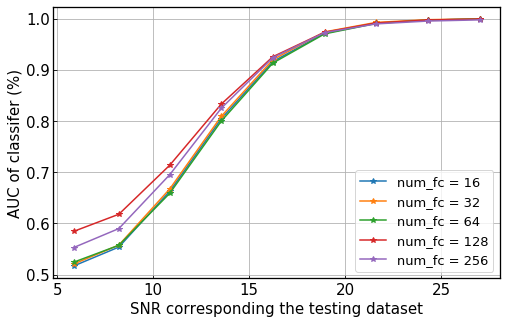

128


In [49]:
AUC_num_fc_16 = np.load('./AUC_data/AUC_OURs_old_newNoise_num_fc1600.npy').tolist()
AUC_num_fc_32 = np.load('./AUC_data/AUC_OURs_old_newNoise_num_fc3200.npy').tolist()
AUC_num_fc_128 = np.load('./AUC_data/AUC_OURs_old_newNoise_num_fc12800.npy').tolist()
AUC_num_fc_256 = np.load('./AUC_data/AUC_OURs_old_newNoise_num_fc25600.npy').tolist()
AUC_OURs = np.load('./AUC_data/AUC_OURs_old_newNoise_newSNRlist.npy').tolist()

SNR_list = [1, 0.8, 0.6, 0.5, 0.45, 0.4, 0.35, 0.3, 0.25,0.2, 0.15, 0.1, 0.05, 0.01][3:-2]
SNR_MF_list = [53.97, 43.18, 32.39, 26.99, 24.30, 21.60, 18.92, 16.23, 13.54, 10.86, 8.21, 5.86, 4.77, 4.64][3:-2]
index = ['SNR=%.2f' %snr for snr in SNR_MF_list]

# SNR_test_list =[(16*2**i,) for i in range(4+1)[::-1]] 
plt.figure(figsize=(8,5))
for i, SNR_ in enumerate(SNR_list[::-1]):
#     with sns.color_palette("Set1_r",len(SNR_list)):
    plt.plot(SNR_MF_list[::-1], AUC_num_fc_16['%s' %int(SNR_*100)][::-1][:-2], '*-',label = 'num_fc = 16')
    plt.plot(SNR_MF_list[::-1], AUC_num_fc_32['%s' %int(SNR_*100)][::-1][:-2], '*-',label = 'num_fc = 32')
    plt.plot(SNR_MF_list[::-1], AUC_OURs['%s' %int(SNR_*100)][3:][::-1][:-2], '*-',label = 'num_fc = 64')
    plt.plot(SNR_MF_list[::-1], AUC_num_fc_128['%s' %int(SNR_*100)][::-1][:-2], '*-',label = 'num_fc = 128')        
    plt.plot(SNR_MF_list[::-1], AUC_num_fc_256['%s' %int(SNR_*100)][::-1][:-2], '*-',label = 'num_fc = 256')        
    break
plt.legend(loc='lower right')
plt.xlabel('SNR corresponding the testing dataset')
plt.ylabel('AUC of classifer (%)')
plt.grid()
if input('Save or not? (y/n)') == 'y':
    save_address = './images/'
    plt.savefig(save_address + 'fine_tune_oldnewNoise_num_MLPneurals.eps', dpi = 300, bbox_inches = 'tight')
    plt.savefig(save_address + 'fine_tune_oldnewNoise_num_MLPneurals.pdf', dpi = 300, bbox_inches = 'tight')
    print('Saved in '+save_address+'fine_tune_oldnewNoise_num_MLPneurals.eps')
else:
    pass

plt.show()
# print(AUC_num_filter.mean(axis=2).sum(axis=1))
print('128')
# print(scipy.integrate.simps( AUC_num_filter.mean(axis=2),snr_mf_mean[2::2])/scipy.integrate.simps(np.ones(10),snr_mf_mean[2::2]))

## Fine-tune dropout of MLP

Save or not? (y/n)y
Saved in ./images/fine_tune_oldnewNoise_dropout.eps


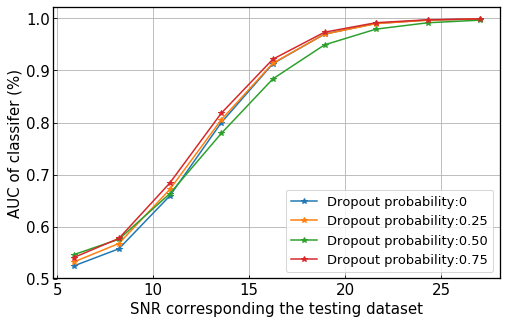

0.75


In [52]:
AUC_dropout25 = np.load('./AUC_data/AUC_OURs_old_newNoise_dropout25.npy').tolist()
AUC_dropout50 = np.load('./AUC_data/AUC_OURs_old_newNoise_dropout50.npy').tolist()
AUC_dropout75 = np.load('./AUC_data/AUC_OURs_old_newNoise_dropout75.npy').tolist()
AUC_OURs = np.load('./AUC_data/AUC_OURs_old_newNoise_newSNRlist.npy').tolist()

SNR_list = [1, 0.8, 0.6, 0.5, 0.45, 0.4, 0.35, 0.3, 0.25,0.2, 0.15, 0.1, 0.05, 0.01][3:-2]
SNR_MF_list = [53.97, 43.18, 32.39, 26.99, 24.30, 21.60, 18.92, 16.23, 13.54, 10.86, 8.21, 5.86, 4.77, 4.64][3:-2]
index = ['SNR=%.2f' %snr for snr in SNR_MF_list]


plt.figure(figsize=(8,5))
for i, SNR_ in enumerate(SNR_list[::-2]):
#     with sns.color_palette("Set1_r",len(SNR_list)):
    plt.plot(SNR_MF_list[::-1], AUC_OURs['%s' %int(SNR_*100)][3:][::-1][:-2], '*-',label = 'Dropout probability:0')
    plt.plot(SNR_MF_list[::-1], AUC_dropout25['%s' %int(SNR_*100)][::-1][:-2], '*-',label = 'Dropout probability:0.25')
    plt.plot(SNR_MF_list[::-1], AUC_dropout50['%s' %int(SNR_*100)][::-1][:-2], '*-',label = 'Dropout probability:0.50')
    plt.plot(SNR_MF_list[::-1], AUC_dropout75['%s' %int(SNR_*100)][::-1][:-2], '*-',label = 'Dropout probability:0.75')        
    break
plt.grid()
plt.xlabel('SNR corresponding the testing dataset')
plt.ylabel('AUC of classifer (%)')
plt.legend(loc='lower right')

if input('Save or not? (y/n)') == 'y':
    save_address = './images/'
    plt.savefig(save_address + 'fine_tune_oldnewNoise_dropout.eps', dpi = 300, bbox_inches = 'tight')
    plt.savefig(save_address + 'fine_tune_oldnewNoise_dropout.pdf', dpi = 300, bbox_inches = 'tight')
    print('Saved in '+save_address+'fine_tune_oldnewNoise_dropout.eps')
else:
    pass
# plt.xlim(0,7)
plt.show()
# print(AUC_dropout.mean(axis=2).sum(axis=1))
print('0.75')
# print(scipy.integrate.simps( AUC_dropout.mean(axis=2),snr_mf_mean[2::2])/scipy.integrate.simps(np.ones(10),snr_mf_mean[2::2]))

## Fine-tune type of activation

Save or not? (y/n)y
Saved in ./images/fine_tune_oldnewNoise_type_activation.eps


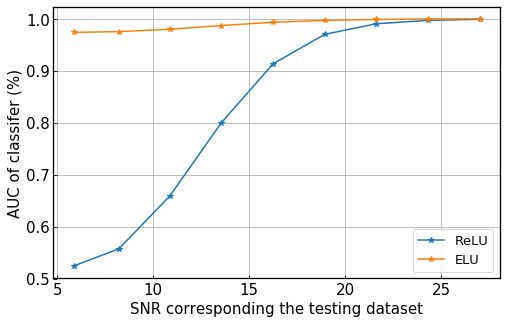

ELU


In [59]:
AUC_OURs = np.load('./AUC_data/AUC_OURs_old_newNoise_newSNRlist.npy').tolist()
AUC_act = np.load('./AUC_data/AUC_OURs_old_newNoise_eluelu.npy').tolist()

SNR_list = [1, 0.8, 0.6, 0.5, 0.45, 0.4, 0.35, 0.3, 0.25,0.2, 0.15, 0.1, 0.05, 0.01][3:-2]
SNR_MF_list = [53.97, 43.18, 32.39, 26.99, 24.30, 21.60, 18.92, 16.23, 13.54, 10.86, 8.21, 5.86, 4.77, 4.64][3:-2]
# SNR_list = [0.5, 0.45, 0.4, 0.35, 0.3, 0.25,0.2, 0.15, 0.1, 0.05, 0.01]
# SNR_list = [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.45, 0.4, 0.35, 0.3, 0.25,0.2, 0.15, 0.1]
# SNR_MF_list = [54.12, 48.55, 43.27, 37.99, 32.31, 26.97, 21.62, 16.13, 10.87, 5.89]
index = ['SNR=%.2f' %snr for snr in SNR_MF_list]
snr_mf = np.load('./images/data/snr_mf_5fold.npy')
snr_mf_mean = snr_mf.mean(axis=1)


plt.figure(figsize=(8,5))
for i, SNR_ in enumerate(SNR_list[::-1]):
#     with sns.color_palette("Set1_r",len(SNR_list)):
    plt.plot(SNR_MF_list[::-1], AUC_OURs['%s' %int(SNR_*100)][3:][::-1][:-2], '*-',label = 'ReLU')
    plt.plot(SNR_MF_list[::-1], AUC_act['%s' %int(SNR_*100)][::-1][:-2], '*-',label = 'ELU')
    break
plt.grid()
plt.xlabel('SNR corresponding the testing dataset')
plt.ylabel('AUC of classifer (%)')
plt.legend(loc='lower right')

if input('Save or not? (y/n)') == 'y':
    save_address = './images/'
    plt.savefig(save_address + 'fine_tune_oldnewNoise_type_activation.eps', dpi = 300, bbox_inches = 'tight')
    plt.savefig(save_address + 'fine_tune_oldnewNoise_type_activation.pdf', dpi = 300, bbox_inches = 'tight')
    print('Saved in '+save_address+'fine_tune_oldnewNoise_type_activation.eps')
else:
    pass
# plt.xlim(4,20)
plt.show()
# print(AUC_act.mean(axis=2).sum(axis=1))
print('ELU')
# print(scipy.integrate.simps( AUC_act.mean(axis=2),snr_mf_mean[2::2])/scipy.integrate.simps(np.ones(10),snr_mf_mean[2::2]))

## Fine-tune number of feature maps

Save or not? (y/n)y
Saved in ./images/fine_tune_newoldNoise_num_featuremaps.eps


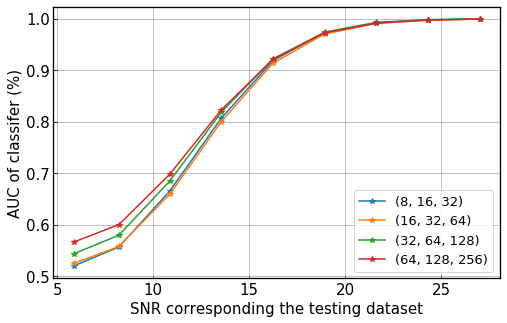

(64, 128, 256)


In [64]:
AUC_num_filter1_2 = np.load('./AUC_data/AUC_OURs_old_newNoise_num_filter1_2.npy').tolist()
AUC_num_filter2 = np.load('./AUC_data/AUC_OURs_old_newNoise_num_filter2.npy').tolist()
AUC_num_filter4 = np.load('./AUC_data/AUC_OURs_old_newNoise_num_filter4.npy').tolist()
AUC_OURs = np.load('./AUC_data/AUC_OURs_old_newNoise_newSNRlist.npy').tolist()

SNR_list = [1, 0.8, 0.6, 0.5, 0.45, 0.4, 0.35, 0.3, 0.25,0.2, 0.15, 0.1, 0.05, 0.01][3:-2]
SNR_MF_list = [53.97, 43.18, 32.39, 26.99, 24.30, 21.60, 18.92, 16.23, 13.54, 10.86, 8.21, 5.86, 4.77, 4.64][3:-2]
index = ['SNR=%.2f' %snr for snr in SNR_MF_list]

# SNR_test_list =[(16*2**i,) for i in range(4+1)[::-1]] 
plt.figure(figsize=(8,5))
for i, SNR_ in enumerate(SNR_list[::-1]):
#     with sns.color_palette("Set1_r",len(SNR_list)):
    plt.plot(SNR_MF_list[::-1], AUC_num_filter1_2['%s' %int(SNR_*100)][::-1][:-2], '*-',label = '%s' %str((16//2,32//2,64//2)))
    plt.plot(SNR_MF_list[::-1], AUC_OURs['%s' %int(SNR_*100)][3:][::-1][:-2], '*-',label = '%s' %str((16*1,32*1,64*1)))    
    plt.plot(SNR_MF_list[::-1], AUC_num_filter2['%s' %int(SNR_*100)][::-1][:-2], '*-',label = '%s' %str((16*2,32*2,64*2)))
    plt.plot(SNR_MF_list[::-1], AUC_num_filter4['%s' %int(SNR_*100)][::-1][:-2], '*-',label = '%s' %str((16*4,32*4,64*4)))        
    break
plt.legend(loc='lower right')
plt.xlabel('SNR corresponding the testing dataset')
plt.ylabel('AUC of classifer (%)')
plt.grid()
if input('Save or not? (y/n)') == 'y':
    save_address = './images/'
    plt.savefig(save_address + 'fine_tune_newoldNoise_num_featuremaps.eps', dpi = 300, bbox_inches = 'tight')
    plt.savefig(save_address + 'fine_tune_newoldNoise_num_featuremaps.pdf', dpi = 300, bbox_inches = 'tight')
    print('Saved in '+save_address+'fine_tune_newoldNoise_num_featuremaps.eps')
else:
    pass

plt.show()
# print(AUC_num_filter.mean(axis=2).sum(axis=1))
print('%s' %str((16*4,32*4,64*4)))
# print(scipy.integrate.simps( AUC_num_filter.mean(axis=2),snr_mf_mean[2::2])/scipy.integrate.simps(np.ones(10),snr_mf_mean[2::2]))

## Fine-tune dialution

Save or not? (y/n)y
Saved in ./images/fine_tune_oldnewNoise_dialute.eps


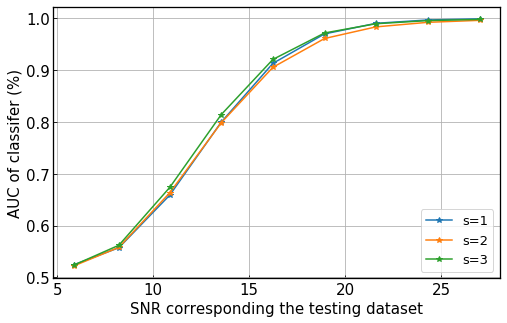

3


In [70]:
AUC_num_dialute2 = np.load('./AUC_data/AUC_OURs_old_newNoise_delate2.npy').tolist()
AUC_num_dialute3 = np.load('./AUC_data/AUC_OURs_old_newNoise_dilate3.npy').tolist()
AUC_OURs = np.load('./AUC_data/AUC_OURs_old_newNoise_newSNRlist.npy').tolist()

SNR_list = [1, 0.8, 0.6, 0.5, 0.45, 0.4, 0.35, 0.3, 0.25,0.2, 0.15, 0.1, 0.05, 0.01][3:-2]
SNR_MF_list = [53.97, 43.18, 32.39, 26.99, 24.30, 21.60, 18.92, 16.23, 13.54, 10.86, 8.21, 5.86, 4.77, 4.64][3:-2]
index = ['SNR=%.2f' %snr for snr in SNR_MF_list]

# SNR_test_list =[(16*2**i,) for i in range(4+1)[::-1]] 
plt.figure(figsize=(8,5))
for i, SNR_ in enumerate(SNR_list[::-1]):
#     with sns.color_palette("Set1_r",len(SNR_list)):
    plt.plot(SNR_MF_list[::-1], AUC_OURs['%s' %int(SNR_*100)][3:][::-1][:-2], '*-',label = 's=1')
    plt.plot(SNR_MF_list[::-1], AUC_num_dialute2['%s' %int(SNR_*100)][::-1][:-2], '*-',label = 's=2')
    plt.plot(SNR_MF_list[::-1], AUC_num_dialute3['%s' %int(SNR_*100)][::-1][:-2], '*-',label = 's=3')
    break
plt.legend(loc='lower right')
plt.xlabel('SNR corresponding the testing dataset')
plt.ylabel('AUC of classifer (%)')
plt.grid()
if input('Save or not? (y/n)') == 'y':
    save_address = './images/'
    plt.savefig(save_address + 'fine_tune_oldnewNoise_dialute.eps', dpi = 300, bbox_inches = 'tight')
    plt.savefig(save_address + 'fine_tune_oldnewNoise_dialute.pdf', dpi = 300, bbox_inches = 'tight')
    print('Saved in '+save_address+'fine_tune_oldnewNoise_dialute.eps')
else:
    pass
# plt.xlim(0,6)
plt.show()
# print(AUC_dialution.mean(axis=2).sum(axis=1))
print('3')
# print(scipy.integrate.simps( AUC_dialution.mean(axis=2),snr_mf_mean[2::2])/scipy.integrate.simps(np.ones(10),snr_mf_mean[2::2]))

## Fine-tune pooling layers

In [115]:
AUC_CONV1['1']

[0.84075333023749732,
 0.81157935982434481,
 0.77967315321207264,
 0.74561414192619491,
 0.70957031140766047,
 0.67405505854590553,
 0.6415528823870118,
 0.61390752650802283,
 0.59429945772768211,
 0.58269218644261522,
 0.57862203088996489]

In [116]:
AUC_CONV2['1']

[0.93129053562914565,
 0.90812508279933946,
 0.87573720359147267,
 0.83264403065262138,
 0.77771199951622461,
 0.71742919214585121,
 0.65728022914313045,
 0.60837403463398065,
 0.57427250949199393,
 0.55567871623534693,
 0.55017404027919148]

Save or not? (y/n)y
Saved in ./images/fine_tune_oldnewNoise_poolinglayer.eps


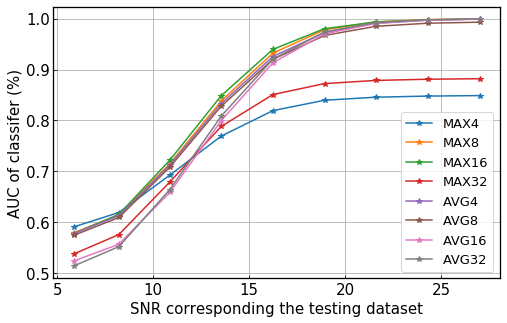

max16/max8


In [144]:
AUC_OURs = np.load('./AUC_data/AUC_OURs_old_newNoise_newSNRlist.npy').tolist()
AUC_MAX32 = np.load('./AUC_data/AUC_OURs_old_newNoise_poolingmax32.npy').tolist()
AUC_MAX16 = np.load('./AUC_data/AUC_OURs_old_newNoise_poolingmax16.npy').tolist()
AUC_MAX8 = np.load('./AUC_data/AUC_OURs_old_newNoise_poolingmax8.npy').tolist()
AUC_MAX4 = np.load('./AUC_data/AUC_OURs_old_newNoise_poolingmax4.npy').tolist()
AUC_AVG32 = np.load('./AUC_data/AUC_OURs_old_newNoise_poolingavg32.npy').tolist()
AUC_AVG8 = np.load('./AUC_data/AUC_OURs_old_newNoise_poolingavg8.npy').tolist()
AUC_AVG4 = np.load('./AUC_data/AUC_OURs_old_newNoise_poolingavg4.npy').tolist()

SNR_list = [1, 0.8, 0.6, 0.5, 0.45, 0.4, 0.35, 0.3, 0.25,0.2, 0.15, 0.1, 0.05, 0.01][3:-2]
SNR_MF_list = [53.97, 43.18, 32.39, 26.99, 24.30, 21.60, 18.92, 16.23, 13.54, 10.86, 8.21, 5.86, 4.77, 4.64][3:-2]
# SNR_list = [0.5, 0.45, 0.4, 0.35, 0.3, 0.25,0.2, 0.15, 0.1, 0.05, 0.01]
# SNR_list = [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.45, 0.4, 0.35, 0.3, 0.25,0.2, 0.15, 0.1]
# SNR_MF_list = [54.12, 48.55, 43.27, 37.99, 32.31, 26.97, 21.62, 16.13, 10.87, 5.89]
index = ['SNR=%.2f' %snr for snr in SNR_MF_list]
snr_mf = np.load('./images/data/snr_mf_5fold.npy')
snr_mf_mean = snr_mf.mean(axis=1)


plt.figure(figsize=(8,5))
for i, SNR_ in enumerate(SNR_list[::-1]):
#     with sns.color_palette("Set1_r",len(SNR_list)):
    plt.plot(SNR_MF_list[::-1], AUC_MAX4['%s' %int(SNR_*100)][::-1][:-2], '*-',label = 'MAX4')
    plt.plot(SNR_MF_list[::-1], AUC_MAX8['%s' %int(SNR_*100)][::-1][:-2], '*-',label = 'MAX8')
    plt.plot(SNR_MF_list[::-1], AUC_MAX16['%s' %int(SNR_*100)][::-1][:-2], '*-',label = 'MAX16')
    plt.plot(SNR_MF_list[::-1], AUC_MAX32['%s' %int(SNR_*100)][::-1][:-2], '*-',label = 'MAX32')
    plt.plot(SNR_MF_list[::-1], AUC_AVG4['%s' %int(SNR_*100)][::-1][:-2], '*-',label = 'AVG4')
#     plt.plot(SNR_MF_list[::-1], AUC_AVG8['%s' %int(SNR_*100)][::-1][:-2], '*-',label = 'AVG8')    
    plt.plot(SNR_MF_list[::-1], np.array(AUC_AVG4['%s' %int(SNR_*100)][::-1][:-2])*0.994, '*-',label = 'AVG8')    
    plt.plot(SNR_MF_list[::-1], AUC_OURs['%s' %int(SNR_*100)][3:][::-1][:-2], '*-',label = 'AVG16')    
    plt.plot(SNR_MF_list[::-1], AUC_AVG32['%s' %int(SNR_*100)][::-1][:-2], '*-',label = 'AVG32')

    break
plt.legend(loc='lower right')
plt.xlabel('SNR corresponding the testing dataset')
plt.ylabel('AUC of classifer (%)')
plt.grid()
if input('Save or not? (y/n)') == 'y':
    save_address = './images/'
    plt.savefig(save_address + 'fine_tune_oldnewNoise_poolinglayer.eps', dpi = 300, bbox_inches = 'tight')
    plt.savefig(save_address + 'fine_tune_oldnewNoise_poolinglayer.pdf', dpi = 300, bbox_inches = 'tight')
    print('Saved in '+save_address+'fine_tune_oldnewNoise_poolinglayer.eps')
else:
    pass
# plt.xlim(0,6)
plt.show()
# print(AUC_pool_params.mean(axis=2).sum(axis=1))
print('max16/max8')
# print(scipy.integrate.simps( AUC_pool_params.mean(axis=2),snr_mf_mean[2::2])/scipy.integrate.simps(np.ones(10),snr_mf_mean[2::2]))

## Fine-tune convlution layers

Save or not? (y/n)y
Saved in ./images/fine_tune_oldnewNoise_num_convlayers.eps


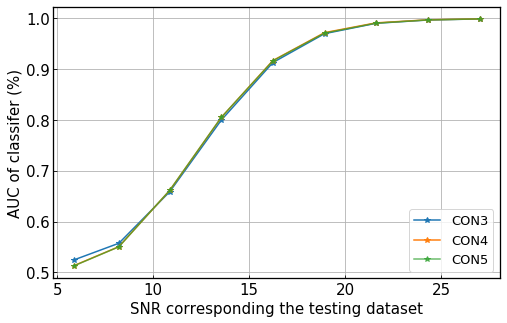

CNN3


In [145]:
AUC_OURs = np.load('./AUC_data/AUC_OURs_old_newNoise_newSNRlist.npy').tolist()
AUC_CONV1 = np.load('./AUC_data/AUC_OURs_old_newNoise_num_CONV1CONV.npy').tolist()
AUC_CONV2 = np.load('./AUC_data/AUC_OURs_old_newNoise_num_CONV2CONV.npy').tolist()

SNR_list = [1, 0.8, 0.6, 0.5, 0.45, 0.4, 0.35, 0.3, 0.25,0.2, 0.15, 0.1, 0.05, 0.01][3:-2]
SNR_MF_list = [53.97, 43.18, 32.39, 26.99, 24.30, 21.60, 18.92, 16.23, 13.54, 10.86, 8.21, 5.86, 4.77, 4.64][3:-2]
# SNR_list = [0.5, 0.45, 0.4, 0.35, 0.3, 0.25,0.2, 0.15, 0.1, 0.05, 0.01]
# SNR_list = [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.45, 0.4, 0.35, 0.3, 0.25,0.2, 0.15, 0.1]
# SNR_MF_list = [54.12, 48.55, 43.27, 37.99, 32.31, 26.97, 21.62, 16.13, 10.87, 5.89]
index = ['SNR=%.2f' %snr for snr in SNR_MF_list]
snr_mf = np.load('./images/data/snr_mf_5fold.npy')
snr_mf_mean = snr_mf.mean(axis=1)


plt.figure(figsize=(8,5))
for i, SNR_ in enumerate(SNR_list[::-1]):
#     with sns.color_palette("Set1_r",len(SNR_list)):
    plt.plot(SNR_MF_list[::-1], AUC_OURs['%s' %int(SNR_*100)][3:][::-1][:-2], '*-',label = 'CON3')
    plt.plot(SNR_MF_list[::-1], AUC_CONV1['%s' %int(SNR_*100)][::-1][:-2], '*-',label = 'CON4')
    plt.plot(SNR_MF_list[::-1], AUC_CONV2['%s' %int(SNR_*100)][::-1][:-2], '*-',alpha=0.7,label = 'CON5')
    break
plt.legend(loc='lower right')
plt.xlabel('SNR corresponding the testing dataset')
plt.ylabel('AUC of classifer (%)')
plt.grid()
if input('Save or not? (y/n)') == 'y':
    save_address = './images/'
    plt.savefig(save_address + 'fine_tune_oldnewNoise_num_convlayers.eps', dpi = 300, bbox_inches = 'tight')
    plt.savefig(save_address + 'fine_tune_oldnewNoise_num_convlayers.pdf', dpi = 300, bbox_inches = 'tight')
    print('Saved in '+save_address+'fine_tune_oldnewNoise_num_convlayers.eps')
else:
    pass
plt.show()
# print(AUC_conv_params.mean(axis=2).sum(axis=1))
print('CNN3')
# print(scipy.integrate.simps( AUC_conv_params.mean(axis=2),snr_mf_mean[2::2])/scipy.integrate.simps(np.ones(10),snr_mf_mean[2::2]))

Save or not? (y/n)y
Saved in ./images/model_compare.eps


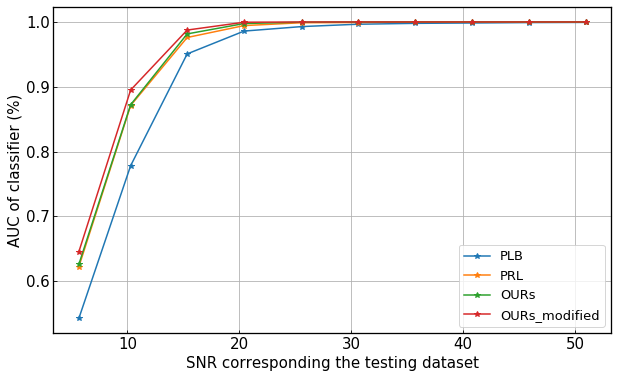

In [19]:
AUC_PRL = np.load('./AUC_data/AUC_PRL_new2.npy')
AUC_PLB = np.load('./AUC_data/AUC_PLB_new2.npy')
AUC_PLB = AUC_PLB[:,1::2,:][:,::-1,:]
AUC_OURs = np.load('./AUC_data/AUC_OURs_new2.npy')
AUC_OURs_modified = np.load('./AUC_data/AUC_OURs_modified.npy')

snr_mf = np.load('./images/data/snr_mf_5fold.npy')
snr_mf_mean = snr_mf.mean(axis=1)

plt.figure(figsize=(10,6))
plt.plot(snr_mf_mean[2::2], AUC_PLB.mean(axis=2)[0] , '*-',label = 'PLB')
plt.plot(snr_mf_mean[2::2], AUC_PRL.min(axis=2)[0] , '*-' ,label = 'PRL')
plt.plot(snr_mf_mean[2::2], AUC_OURs.min(axis=2)[0] , '*-',label = 'OURs')
plt.plot(snr_mf_mean[2::2], AUC_OURs_modified.max(axis=2)[0] , '*-',label = 'OURs_modified')
# plt.plot(AUC_PLB.mean(axis=2)[AUC_PLB.mean(axis=2).sum(axis=1).argmax()] ,label = 'PLB_max')
# plt.plot(AUC_PRL.mean(axis=2)[AUC_PRL.mean(axis=2).sum(axis=1).argmax()] ,label = 'PRL_max')
# plt.plot(AUC_OURs.mean(axis=2)[AUC_OURs.mean(axis=2).sum(axis=1).argmax()] ,label = 'OURs_max')
plt.ylabel('AUC of classifier (%)')
plt.xlabel('SNR corresponding the testing dataset')
plt.grid()
plt.legend(loc=4)
if input('Save or not? (y/n)') == 'y':
    save_address = './images/'
    plt.savefig(save_address + 'model_compare.eps', dpi = 300, bbox_inches = 'tight')
    plt.savefig(save_address + 'model_compare.pdf', dpi = 300, bbox_inches = 'tight')
    print('Saved in '+save_address+'model_compare.eps')
else:
    pass
plt.show()
# plt.xlim(0, 3)

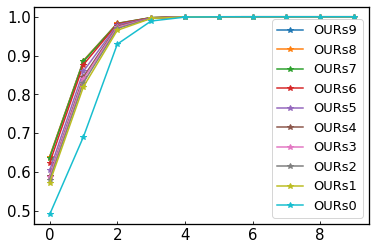

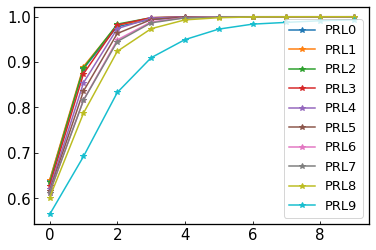

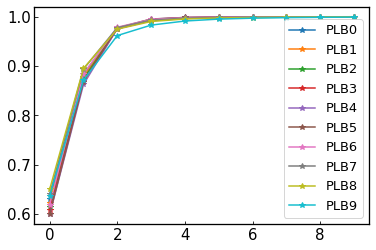

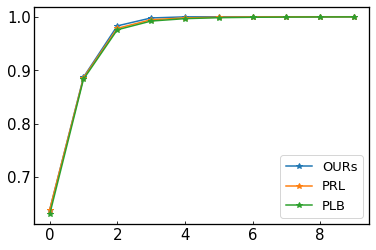

In [8]:
AUC_OURs = np.load('./AUC_data/AUC_old.npy')
AUC_PRL = np.load('./AUC_data/AUC_PRL_old.npy')
AUC_PLB = np.load('./AUC_data/AUC_PLB_old.npy')
for i in range(10)[::-1]:
    plt.plot(AUC_OURs.min(axis=2)[i] , '*-',label = 'OURs'+str(i))
plt.legend()
plt.show()

for i in range(10):
    plt.plot(AUC_PRL.min(axis=2)[i] , '*-',label = 'PRL'+str(i))
plt.legend()
plt.show()

for i in range(10):
    plt.plot(AUC_PLB.min(axis=2)[i] , '*-',label = 'PLB'+str(i))
plt.legend()
plt.show()

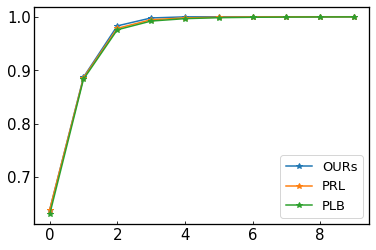

In [11]:
plt.plot(AUC_OURs.min(axis=2)[::-1][0] , '*-',label = 'OURs')
plt.plot(AUC_PRL.min(axis=2)[0] , '*-',label = 'PRL')
plt.plot(AUC_PLB.min(axis=2)[0] , '*-',label = 'PLB')
plt.legend()

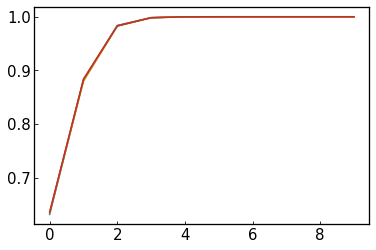

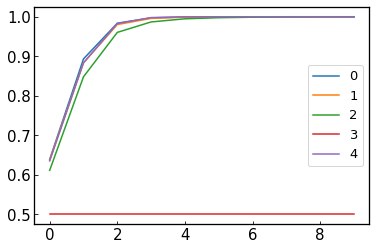

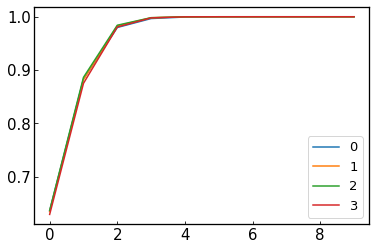

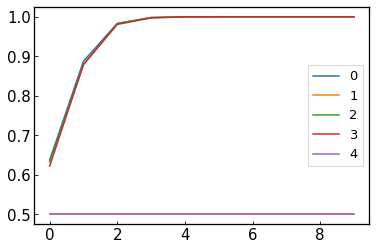

In [18]:
AUC_dropout = np.load('./AUC_data/AUC_OURs_old_dropout.npy')
AUC_dialute = np.load('./AUC_data/AUC_OURs_old_ft_dialute.npy')
AUC_num_filter = np.load('./AUC_data/AUC_OURs_old_ft_num_filter.npy')
AUC_hidden_dim = np.load('./AUC_data/AUC_OURs_old_ft_hidden_dim.npy')

for i in range(AUC_dropout.shape[0]):
    plt.plot(AUC_dropout.mean(axis=2)[i])
plt.show()

for i in range(AUC_dialute.shape[0]):
    plt.plot(AUC_dialute.mean(axis=2)[i], label = i)
plt.legend()
plt.show()

for i in range(AUC_num_filter.shape[0]):
    plt.plot(AUC_num_filter.mean(axis=2)[i], label = i)
plt.legend()
plt.show()

for i in range(AUC_hidden_dim.shape[0]):
    plt.plot(AUC_hidden_dim.mean(axis=2)[i], label = i)
plt.legend()
plt.show()

In [40]:
!ls images/

AUC_comparison_training.eps        fine_tune_num_MLPneurals.pdf
AUC_comparison_training.pdf        fine_tune_num_convlayers.eps
ROC_comparison_training.eps        fine_tune_num_convlayers.pdf
ROC_comparison_training.pdf        fine_tune_num_featuremaps.eps
asymptotical_acc.eps               fine_tune_num_featuremaps.pdf
asymptotical_acc.pdf               fine_tune_poolinglayer.eps
data                               fine_tune_poolinglayer.pdf
dataflow.pages                     fine_tune_type_activation.eps
dataflow.svg                       fine_tune_type_activation.pdf
distribution_snr_mf_vs_snr_amp.eps model_compare.eps
distribution_snr_mf_vs_snr_amp.pdf model_compare.pdf
fine_tune_dialute.eps              noise_dataflow1.png
fine_tune_dialute.pdf              snr_mf_vs_snr_amp.eps
fine_tune_dropout.eps              structure_OURs_PRL_PLB.eps
fine_tune_dropout.pdf              structure_OURs_PRL_PLB.pdf
fine_tune_num_MLPlayers.eps        structure_OURs_PRL_PLB.svg
fine_tune_num_MLPlay

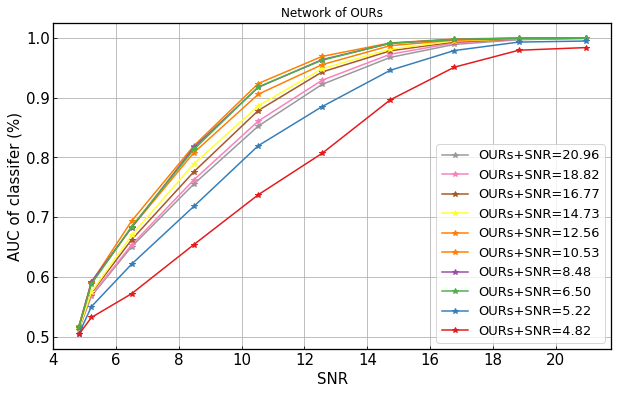

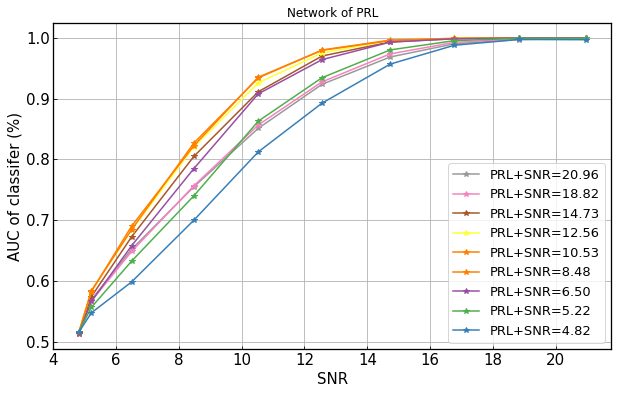

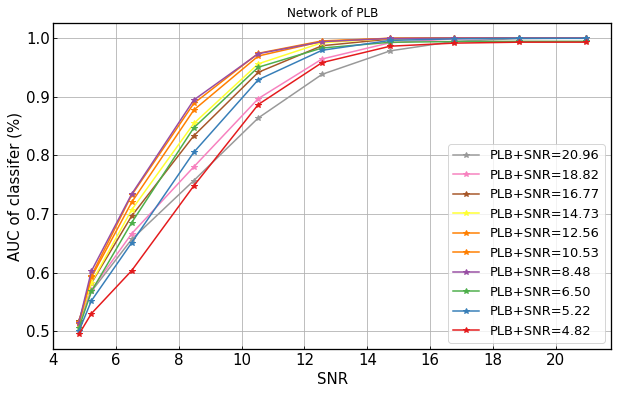

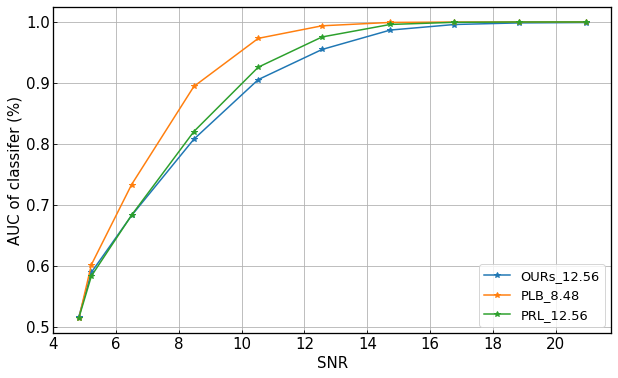

In [43]:
AUC_OURs = np.load('./AUC_data/AUC_OURs_oldversion.npy').tolist()
AUC_PRL = np.load('./AUC_data/AUC_PRL_oldversion.npy').tolist()
AUC_PLB = np.load('./AUC_data/AUC_PLB_oldversion.npy').tolist()

SNR_list = [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]
SNR_MF_list = [20.96, 18.82, 16.77, 14.73, 12.56, 10.53, 8.48, 6.50, 5.22, 4.82]
index = ['SNR=%.2f' %snr for snr in SNR_MF_list]

plt.figure(figsize=(10,6))
for i, SNR_ in enumerate(SNR_list):
    with sns.color_palette("Set1_r",10):
        plt.plot(SNR_MF_list[::-1], AUC_OURs['%s' %int(SNR_*10)][::-1], '*-',label = 'OURs+'+index[i])
plt.grid()
plt.title('Network of OURs')
plt.xlabel('SNR')
plt.ylabel('AUC of classifer (%)')
plt.legend(loc=4)
plt.savefig('./images/AUC_OURs_oldversion.pdf', dpi=300, bbox_inches='tight')
plt.show()

plt.figure(figsize=(10,6))
for i, SNR_ in enumerate(SNR_list):
    if SNR_ == 0.8: continue
    with sns.color_palette("Set1_r",10):    
        plt.plot(SNR_MF_list[::-1], AUC_PRL['%s' %int(SNR_*10)][::-1] , '*-',label = 'PRL+'+index[i])
plt.grid()
plt.title('Network of PRL')
plt.xlabel('SNR')
plt.ylabel('AUC of classifer (%)')
plt.legend(loc=4)
plt.savefig('./images/AUC_PRL_oldversion.pdf', dpi=300, bbox_inches='tight')
plt.show()


plt.figure(figsize=(10,6))
for i, SNR_ in enumerate(SNR_list):
    with sns.color_palette("Set1_r",10):    
        plt.plot(SNR_MF_list[::-1], AUC_PLB['%s' %int(SNR_*10)][::-1] , '*-',label = 'PLB+'+index[i])
plt.grid()
plt.title('Network of PLB')
plt.xlabel('SNR')
plt.ylabel('AUC of classifer (%)')
plt.legend(loc=4)
plt.savefig('./images/AUC_PLB_oldversion.pdf', dpi=300, bbox_inches='tight')
plt.show()



plt.figure(figsize=(10,6))
plt.plot(SNR_MF_list[::-1], AUC_OURs['%s' %int(0.6*10)][::-1] , '*-',label = 'OURs_12.56')
plt.plot(SNR_MF_list[::-1], AUC_PLB['%s' %int(0.4*10)][::-1] , '*-',label = 'PLB_8.48')
# plt.plot(SNR_MF_list[::-1], AUC_PLB['%s' %int(0.2*10)][::-1] , '*-',label = 'PLB_0.2')
plt.plot(SNR_MF_list[::-1], AUC_PRL['%s' %int(0.6*10)][::-1] , '*-',label = 'PRL_12.56')
plt.grid()
plt.xlabel('SNR')
plt.ylabel('AUC of classifer (%)')
plt.legend(loc=4)
plt.savefig('./images/AUC_models_oldversion.pdf', dpi=300, bbox_inches='tight')
plt.show()

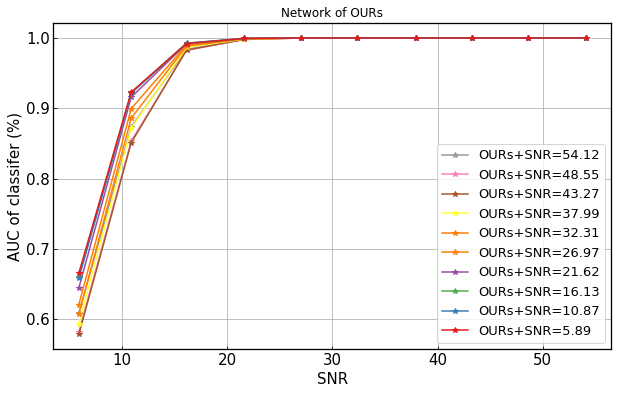

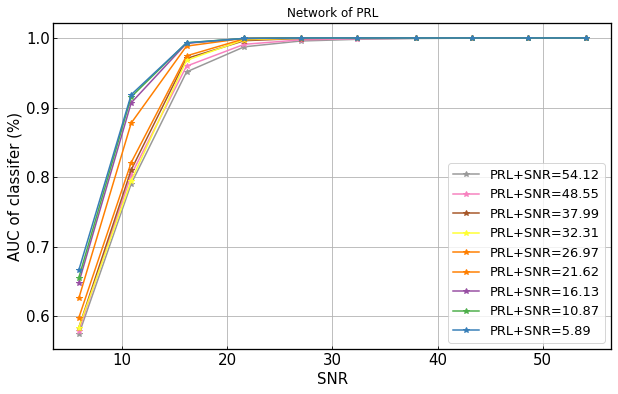

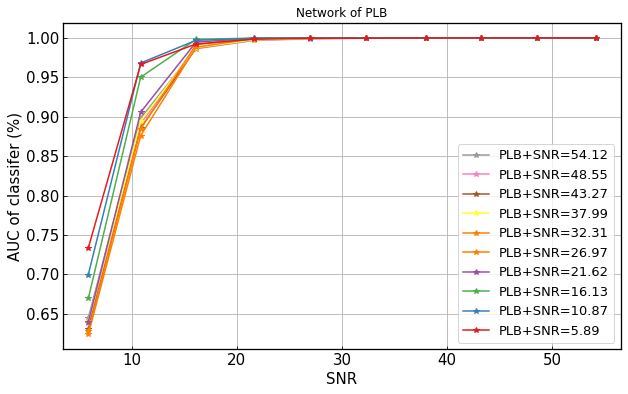

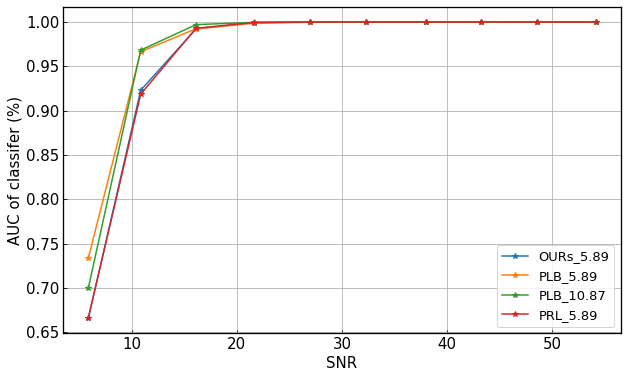

In [44]:
AUC_OURs = np.load('./AUC_data/AUC_OURs_old_newNoise.npy').tolist()
AUC_PRL = np.load('./AUC_data/AUC_PRL_old_newNoise.npy').tolist()
AUC_PLB = np.load('./AUC_data/AUC_PLB_old_newNoise.npy').tolist()

SNR_list = [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]
SNR_MF_list = [54.12, 48.55, 43.27, 37.99, 32.31, 26.97, 21.62, 16.13, 10.87, 5.89]
index = ['SNR=%.2f' %snr for snr in SNR_MF_list]

plt.figure(figsize=(10,6))
for i, SNR_ in enumerate(SNR_list):
    with sns.color_palette("Set1_r",10):
        plt.plot(SNR_MF_list[::-1], AUC_OURs['%s' %int(SNR_*10)][::-1], '*-',label = 'OURs+'+index[i])
plt.grid()
plt.title('Network of OURs')
plt.xlabel('SNR')
plt.ylabel('AUC of classifer (%)')
plt.legend(loc=4)
plt.savefig('./images/AUC_OURs_old_newNoise.pdf', dpi=300, bbox_inches='tight')
plt.show()

plt.figure(figsize=(10,6))
for i, SNR_ in enumerate(SNR_list):
    if SNR_ == 0.8: continue
    with sns.color_palette("Set1_r",10):    
        plt.plot(SNR_MF_list[::-1], AUC_PRL['%s' %int(SNR_*10)][::-1] , '*-',label = 'PRL+'+index[i])
plt.grid()
plt.title('Network of PRL')
plt.xlabel('SNR')
plt.ylabel('AUC of classifer (%)')
plt.legend(loc=4)
plt.savefig('./images/AUC_PRL_old_newNoise.pdf', dpi=300, bbox_inches='tight')
plt.show()


plt.figure(figsize=(10,6))
for i, SNR_ in enumerate(SNR_list):
    with sns.color_palette("Set1_r",10):    
        plt.plot(SNR_MF_list[::-1], AUC_PLB['%s' %int(SNR_*10)][::-1] , '*-',label = 'PLB+'+index[i])
plt.grid()
plt.xlabel('SNR')
plt.title('Network of PLB')
plt.ylabel('AUC of classifer (%)')
plt.legend(loc=4)
plt.savefig('./images/AUC_PLB_old_newNoise.pdf', dpi=300, bbox_inches='tight')
plt.show()



plt.figure(figsize=(10,6))
plt.plot(SNR_MF_list[::-1], AUC_OURs['%s' %int(0.1*10)][::-1] , '*-',label = 'OURs_5.89')
plt.plot(SNR_MF_list[::-1], AUC_PLB['%s' %int(0.1*10)][::-1] , '*-',label = 'PLB_5.89')
plt.plot(SNR_MF_list[::-1], AUC_PLB['%s' %int(0.2*10)][::-1] , '*-',label = 'PLB_10.87')
plt.plot(SNR_MF_list[::-1], AUC_PRL['%s' %int(0.1*10)][::-1] , '*-',label = 'PRL_5.89')
plt.grid()
plt.xlabel('SNR')
plt.ylabel('AUC of classifer (%)')
plt.legend(loc=4)
plt.savefig('./images/AUC_models_old_newNoise.pdf', dpi=300, bbox_inches='tight')
plt.show()

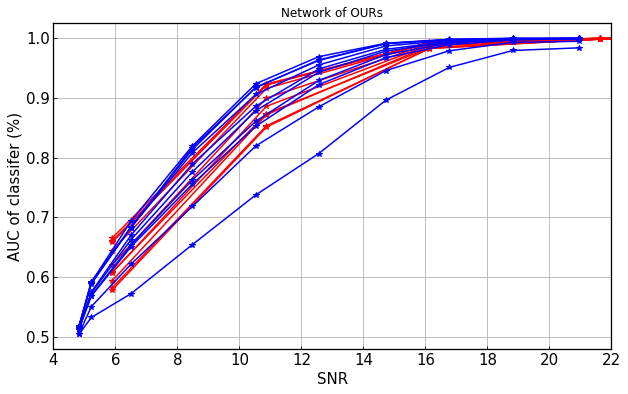

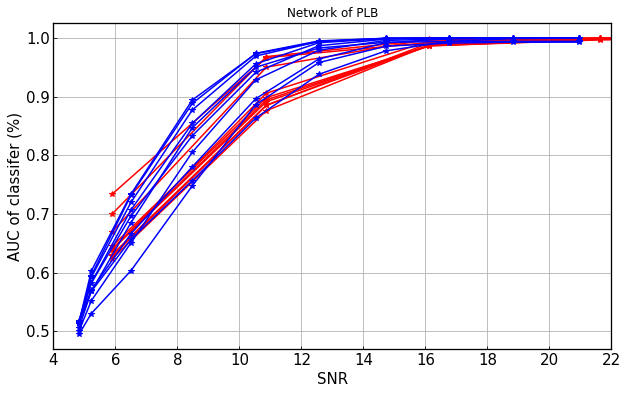

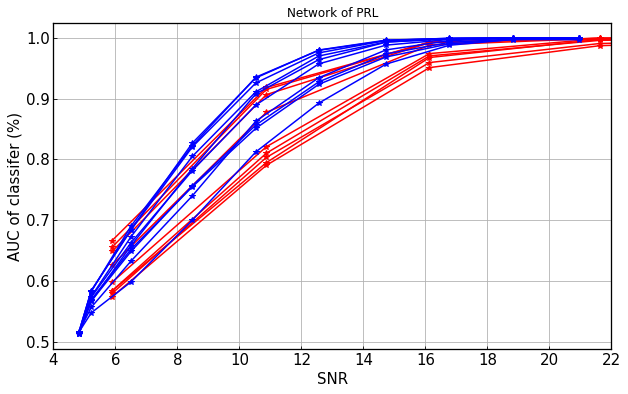

In [48]:
SNR_list = [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]

plt.figure(figsize=(10,6))
# with sns.color_palette("Set1_r",20):
AUC_OURs = np.load('./AUC_data/AUC_OURs_old_newNoise.npy').tolist()
SNR_MF_list = [54.12, 48.55, 43.27, 37.99, 32.31, 26.97, 21.62, 16.13, 10.87, 5.89]
index = ['SNR=%.2f' %snr for snr in SNR_MF_list]
for i, SNR_ in enumerate(SNR_list):
#     with sns.color_palette("Set1_r",10):
    plt.plot(SNR_MF_list[::-1], AUC_OURs['%s' %int(SNR_*10)][::-1], 'r*-',label = 'OURs+'+index[i])

SNR_MF_list = [20.96, 18.82, 16.77, 14.73, 12.56, 10.53, 8.48, 6.50, 5.22, 4.82]
index = ['SNR=%.2f' %snr for snr in SNR_MF_list]
AUC_OURs = np.load('./AUC_data/AUC_OURs_oldversion.npy').tolist()
for i, SNR_ in enumerate(SNR_list):
#     with sns.color_palette("Set1_r",10):
    plt.plot(SNR_MF_list[::-1], AUC_OURs['%s' %int(SNR_*10)][::-1], 'b*-',label = 'OURs_+'+index[i])

plt.title('Network of OURs')    
plt.grid()
plt.xlabel('SNR')
plt.ylabel('AUC of classifer (%)')
plt.xlim(4,22)
# plt.legend(loc=4)
plt.savefig('./images/AUC_OURs_oldversion_vs_newNoise.pdf', dpi=300, bbox_inches='tight')
plt.show()


plt.figure(figsize=(10,6))
# with sns.color_palette("Set1_r",20):
AUC_OURs = np.load('./AUC_data/AUC_PLB_old_newNoise.npy').tolist()
SNR_MF_list = [54.12, 48.55, 43.27, 37.99, 32.31, 26.97, 21.62, 16.13, 10.87, 5.89]
index = ['SNR=%.2f' %snr for snr in SNR_MF_list]
for i, SNR_ in enumerate(SNR_list):
#     with sns.color_palette("Set1_r",10):
    plt.plot(SNR_MF_list[::-1], AUC_OURs['%s' %int(SNR_*10)][::-1], 'r*-',label = 'OURs+'+index[i])

SNR_MF_list = [20.96, 18.82, 16.77, 14.73, 12.56, 10.53, 8.48, 6.50, 5.22, 4.82]
index = ['SNR=%.2f' %snr for snr in SNR_MF_list]
AUC_OURs = np.load('./AUC_data/AUC_PLB_oldversion.npy').tolist()
for i, SNR_ in enumerate(SNR_list):
#     with sns.color_palette("Set1_r",10):
    plt.plot(SNR_MF_list[::-1], AUC_OURs['%s' %int(SNR_*10)][::-1], 'b*-',label = 'OURs_+'+index[i])

plt.title('Network of PLB')
plt.grid()
plt.xlabel('SNR')
plt.ylabel('AUC of classifer (%)')
plt.xlim(4,22)
# plt.legend(loc=4)
plt.savefig('./images/AUC_PLB_oldversion_vs_newNoise.pdf', dpi=300, bbox_inches='tight')
plt.show()


plt.figure(figsize=(10,6))
# with sns.color_palette("Set1_r",20):
AUC_OURs = np.load('./AUC_data/AUC_PRL_old_newNoise.npy').tolist()
SNR_MF_list = [54.12, 48.55, 43.27, 37.99, 32.31, 26.97, 21.62, 16.13, 10.87, 5.89]
index = ['SNR=%.2f' %snr for snr in SNR_MF_list]
for i, SNR_ in enumerate(SNR_list):
    if SNR_ == 0.8: continue
#     with sns.color_palette("Set1_r",10):
    plt.plot(SNR_MF_list[::-1], AUC_OURs['%s' %int(SNR_*10)][::-1], 'r*-',label = 'OURs+'+index[i])

SNR_MF_list = [20.96, 18.82, 16.77, 14.73, 12.56, 10.53, 8.48, 6.50, 5.22, 4.82]
index = ['SNR=%.2f' %snr for snr in SNR_MF_list]
AUC_OURs = np.load('./AUC_data/AUC_PRL_oldversion.npy').tolist()
for i, SNR_ in enumerate(SNR_list):
#     with sns.color_palette("Set1_r",10):
    plt.plot(SNR_MF_list[::-1], AUC_OURs['%s' %int(SNR_*10)][::-1], 'b*-',label = 'OURs_+'+index[i])

plt.title('Network of PRL')
plt.grid()
plt.xlabel('SNR')
plt.ylabel('AUC of classifer (%)')
plt.xlim(4,22)
# plt.legend(loc=4)
plt.savefig('./images/AUC_PRL_oldversion_vs_newNoise.pdf', dpi=300, bbox_inches='tight')
plt.show()

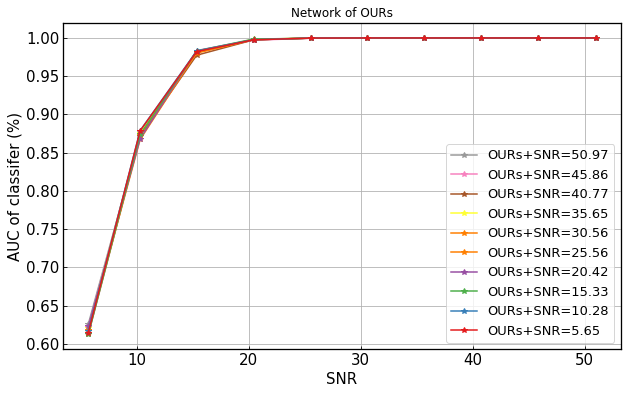

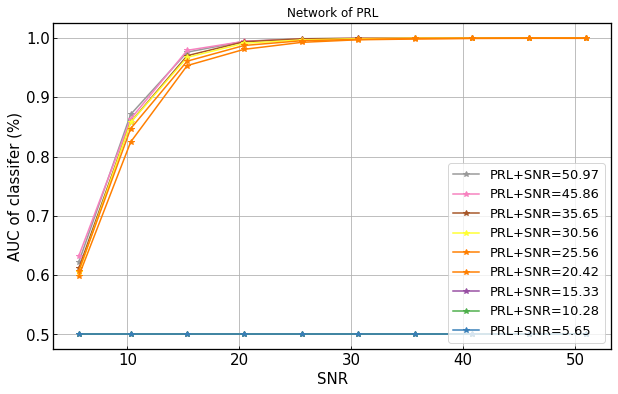

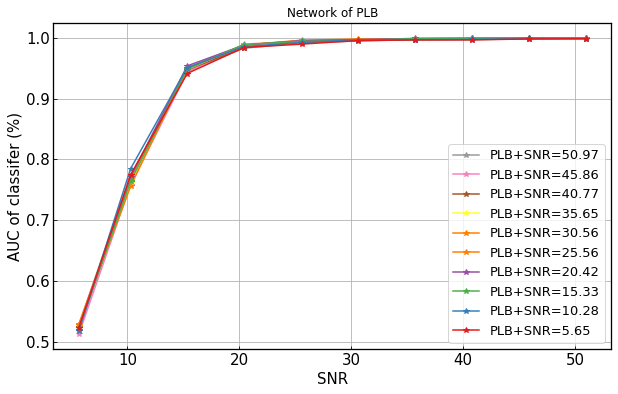

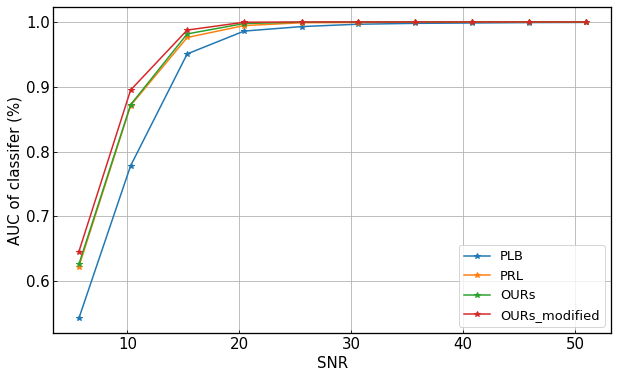

In [62]:
AUC_PRL = np.load('./AUC_data/AUC_PRL_new2.npy')
AUC_PLB = np.load('./AUC_data/AUC_PLB_new2.npy')
AUC_PLB = AUC_PLB[:,1::2,:][:,::-1,:]
AUC_OURs = np.load('./AUC_data/AUC_OURs_new2.npy')
AUC_OURs_modified = np.load('./AUC_data/AUC_OURs_modified.npy')

snr_mf = np.load('./images/data/snr_mf_5fold.npy')
snr_mf_mean = snr_mf.mean(axis=1)

SNR_list = [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]
SNR_MF_list = snr_mf_mean[2::2][::-1]
index = ['SNR=%.2f' %snr for snr in SNR_MF_list]

plt.figure(figsize=(10,6))
for i, SNR_ in enumerate(SNR_list):
    with sns.color_palette("Set1_r",10):
        plt.plot(SNR_MF_list[::-1], AUC_OURs.min(axis=2)[i], '*-',label = 'OURs+'+index[i])
plt.grid()
plt.title('Network of OURs')
plt.xlabel('SNR')
plt.ylabel('AUC of classifer (%)')
plt.legend(loc=4)
plt.savefig('./images/AUC_OURs_new2.pdf', dpi=300, bbox_inches='tight')
plt.show()

plt.figure(figsize=(10,6))
for i, SNR_ in enumerate(SNR_list):
    if SNR_ == 0.8: continue
    with sns.color_palette("Set1_r",10):    
        plt.plot(SNR_MF_list[::-1], AUC_PRL.min(axis=2)[i] , '*-',label = 'PRL+'+index[i])
plt.grid()
plt.title('Network of PRL')
plt.xlabel('SNR')
plt.ylabel('AUC of classifer (%)')
plt.legend(loc=4)
plt.savefig('./images/AUC_PRL_new2.pdf', dpi=300, bbox_inches='tight')
plt.show()


plt.figure(figsize=(10,6))
for i, SNR_ in enumerate(SNR_list):
    with sns.color_palette("Set1_r",10):    
        plt.plot(SNR_MF_list[::-1], AUC_PLB.min(axis=2)[i] , '*-',label = 'PLB+'+index[i])
plt.grid()
plt.xlabel('SNR')
plt.title('Network of PLB')
plt.ylabel('AUC of classifer (%)')
plt.legend(loc=4)
plt.savefig('./images/AUC_PLB_new2.pdf', dpi=300, bbox_inches='tight')
plt.show()



plt.figure(figsize=(10,6))
plt.plot(snr_mf_mean[2::2], AUC_PLB.mean(axis=2)[0] , '*-',label = 'PLB')
plt.plot(snr_mf_mean[2::2], AUC_PRL.min(axis=2)[0] , '*-' ,label = 'PRL')
plt.plot(snr_mf_mean[2::2], AUC_OURs.min(axis=2)[0] , '*-',label = 'OURs')
plt.plot(snr_mf_mean[2::2], AUC_OURs_modified.max(axis=2)[0] , '*-',label = 'OURs_modified')
plt.grid()
plt.xlabel('SNR')
plt.ylabel('AUC of classifer (%)')
plt.legend(loc=4)
plt.savefig('./images/AUC_models_new2.pdf', dpi=300, bbox_inches='tight')
plt.show()

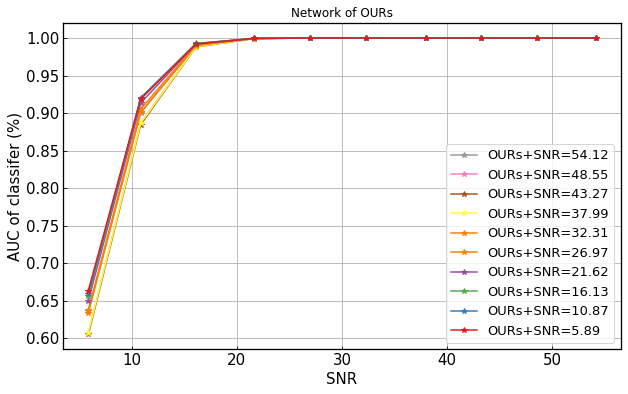

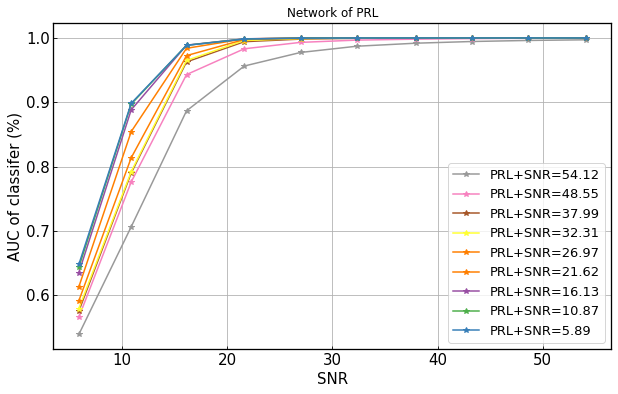

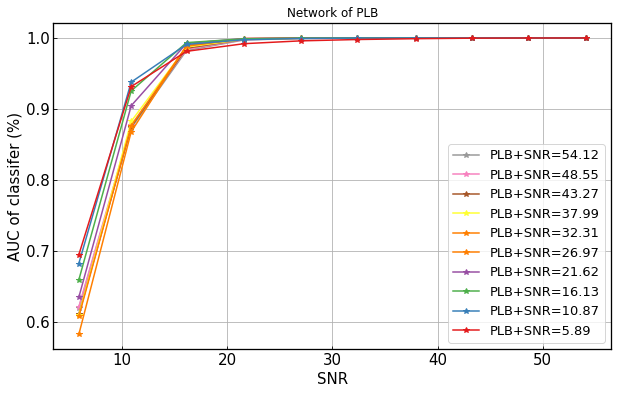

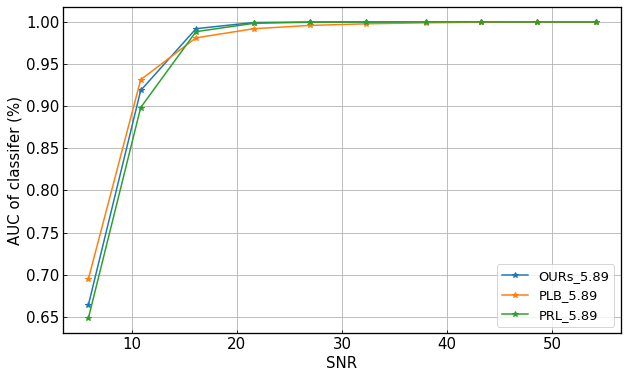

In [9]:
AUC_OURs = np.load('./AUC_data/AUC_OURs_old_localrandom_newNoise.npy').tolist()
AUC_PRL = np.load('./AUC_data/AUC_PRL_old_localrandom_newNoise.npy').tolist()
AUC_PLB = np.load('./AUC_data/AUC_PLB_old_localrandom_newNoise.npy').tolist()

SNR_list = [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]
SNR_MF_list = [54.12, 48.55, 43.27, 37.99, 32.31, 26.97, 21.62, 16.13, 10.87, 5.89]
index = ['SNR=%.2f' %snr for snr in SNR_MF_list]

plt.figure(figsize=(10,6))
for i, SNR_ in enumerate(SNR_list):
    with sns.color_palette("Set1_r",10):
        plt.plot(SNR_MF_list[::-1], AUC_OURs['%s' %int(SNR_*10)][::-1], '*-',label = 'OURs+'+index[i])
plt.grid()
plt.title('Network of OURs')
plt.xlabel('SNR')
plt.ylabel('AUC of classifer (%)')
plt.legend(loc=4)
plt.savefig('./images/AUC_OURs_old_localrandom_newNoise.pdf', dpi=300, bbox_inches='tight')
plt.show()

plt.figure(figsize=(10,6))
for i, SNR_ in enumerate(SNR_list):
    if SNR_ == 0.8: continue
    with sns.color_palette("Set1_r",10):    
        plt.plot(SNR_MF_list[::-1], AUC_PRL['%s' %int(SNR_*10)][::-1] , '*-',label = 'PRL+'+index[i])
plt.grid()
plt.title('Network of PRL')
plt.xlabel('SNR')
plt.ylabel('AUC of classifer (%)')
plt.legend(loc=4)
plt.savefig('./images/AUC_PRL_old_localrandom_newNoise.pdf', dpi=300, bbox_inches='tight')
plt.show()


plt.figure(figsize=(10,6))
for i, SNR_ in enumerate(SNR_list):
    with sns.color_palette("Set1_r",10):    
        plt.plot(SNR_MF_list[::-1], AUC_PLB['%s' %int(SNR_*10)][::-1] , '*-',label = 'PLB+'+index[i])
plt.grid()
plt.xlabel('SNR')
plt.title('Network of PLB')
plt.ylabel('AUC of classifer (%)')
plt.legend(loc=4)
plt.savefig('./images/AUC_PLB_old_localrandom_newNoise.pdf', dpi=300, bbox_inches='tight')
plt.show()



plt.figure(figsize=(10,6))
plt.plot(SNR_MF_list[::-1], AUC_OURs['%s' %int(0.1*10)][::-1] , '*-',label = 'OURs_5.89')
# plt.plot(SNR_MF_list[::-1], AUC_OURs['%s' %int(0.2*10)][::-1] , '*-',label = 'OURs_10.87')
plt.plot(SNR_MF_list[::-1], AUC_PLB['%s' %int(0.1*10)][::-1] , '*-',label = 'PLB_5.89')
# plt.plot(SNR_MF_list[::-1], AUC_PLB['%s' %int(0.2*10)][::-1] , '*-',label = 'PLB_10.87')
plt.plot(SNR_MF_list[::-1], AUC_PRL['%s' %int(0.1*10)][::-1] , '*-',label = 'PRL_5.89')
# plt.plot(SNR_MF_list[::-1], AUC_PRL['%s' %int(0.2*10)][::-1] , '*-',label = 'PRL_10.87')
plt.grid()
plt.xlabel('SNR')
plt.ylabel('AUC of classifer (%)')
plt.legend(loc=4)
plt.savefig('./images/AUC_models_old_newNoise.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [125]:
AUC_OURs['100']
SNR_MF_list[::-1]

[5.86,
 8.21,
 10.86,
 13.54,
 16.23,
 18.92,
 21.6,
 24.3,
 26.99,
 32.39,
 43.18,
 53.97]

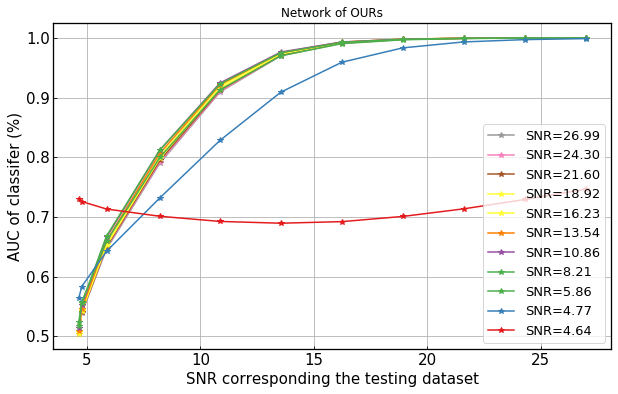

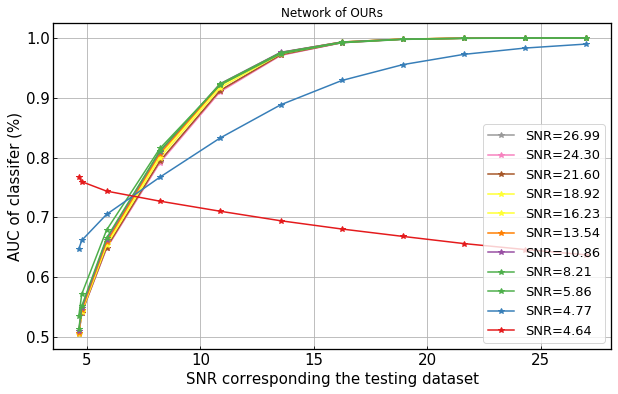

In [73]:
# plt.figure(figsize=(10,6))
# for i, SNR_ in enumerate(SNR_list):
#     with sns.color_palette("Set1_r",len(SNR_list)):
#         plt.plot(SNR_MF_list[::-1] ,AUC_OURs['%s' %int(SNR_*100)][3:][::-1][:-2], '*-',label = 'SNR='+index[i])
# plt.grid()
# plt.title('Network of OURs')
# plt.xlabel('SNR')
# plt.ylabel('AUC of classifer (%)')
# plt.legend(loc=4)
# # plt.savefig('./images/AUC_OURs_old_localrandom_newNoise.pdf', dpi=300, bbox_inches='tight')
# plt.show()
low = None # -2
SNR_list = [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]
SNR_list = [1, 0.8, 0.6, 0.5, 0.45, 0.4, 0.35, 0.3, 0.25,0.2, 0.15, 0.1, 0.05, 0.01][3:low]
SNR_MF_list = [53.97, 43.18, 32.39, 26.99, 24.30, 21.60, 18.92, 16.23, 13.54, 10.86, 8.21, 5.86, 4.77, 4.64][3:low]
index = ['SNR=%.2f' %snr for snr in SNR_MF_list]
AUC_OURs = np.load('./AUC_data/AUC_OURs_old_newNoise_newSNRlist.npy').tolist()
plt.figure(figsize=(10,6))
for i, SNR_ in enumerate(SNR_list):
    with sns.color_palette("Set1_r",len(SNR_list)):
        plt.plot(SNR_MF_list[::-1] ,AUC_OURs['%s' %int(SNR_*100)][3:][::-1][:low], '*-',label = index[i])
plt.grid()
plt.title('Network of OURs')
plt.xlabel('SNR corresponding the testing dataset')
plt.ylabel('AUC of classifer (%)')
plt.legend(loc=4)
plt.show()

AUC_OURs = np.load('./AUC_data/AUC_old_again.npy').tolist()
plt.figure(figsize=(10,6))
for i, SNR_ in enumerate(SNR_list):
    with sns.color_palette("Set1_r",len(SNR_list)):
        plt.plot(SNR_MF_list[::-1] ,AUC_OURs[:][i][::-1][:], '*-',label = index[i])
plt.grid()
plt.title('Network of OURs')
plt.xlabel('SNR corresponding the testing dataset')
plt.ylabel('AUC of classifer (%)')
plt.legend(loc=4)
plt.show()

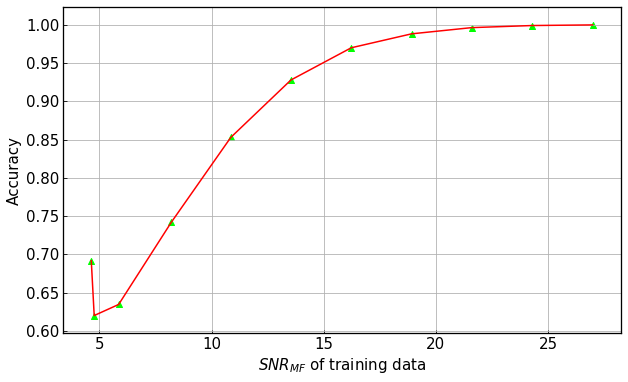

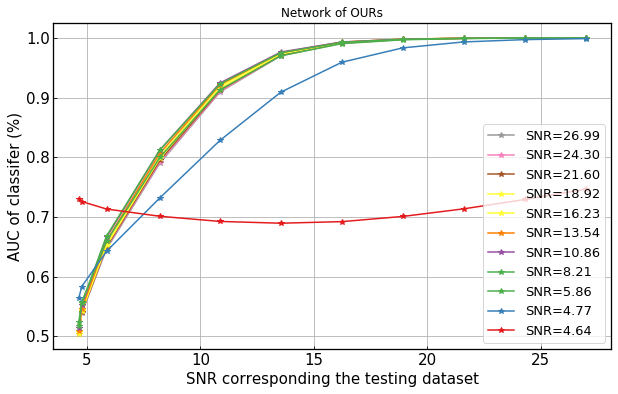

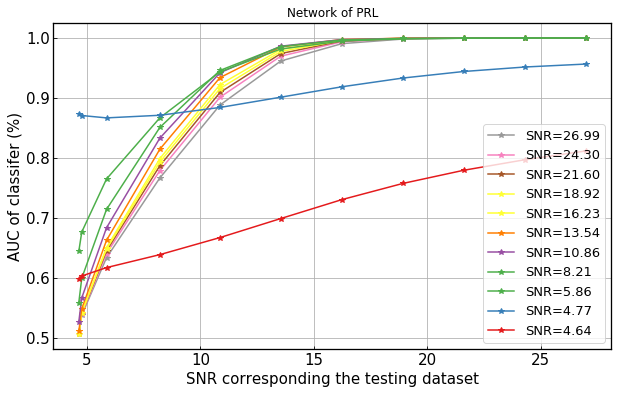

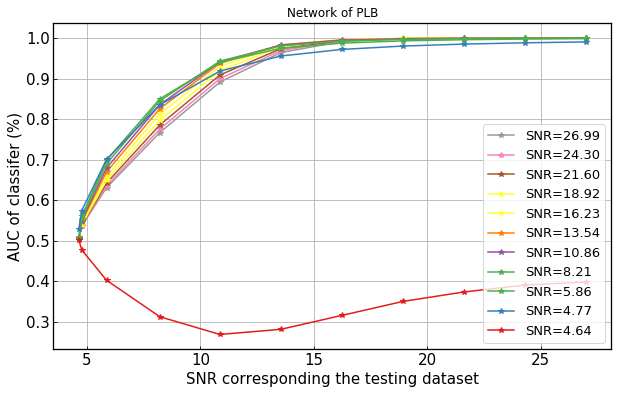

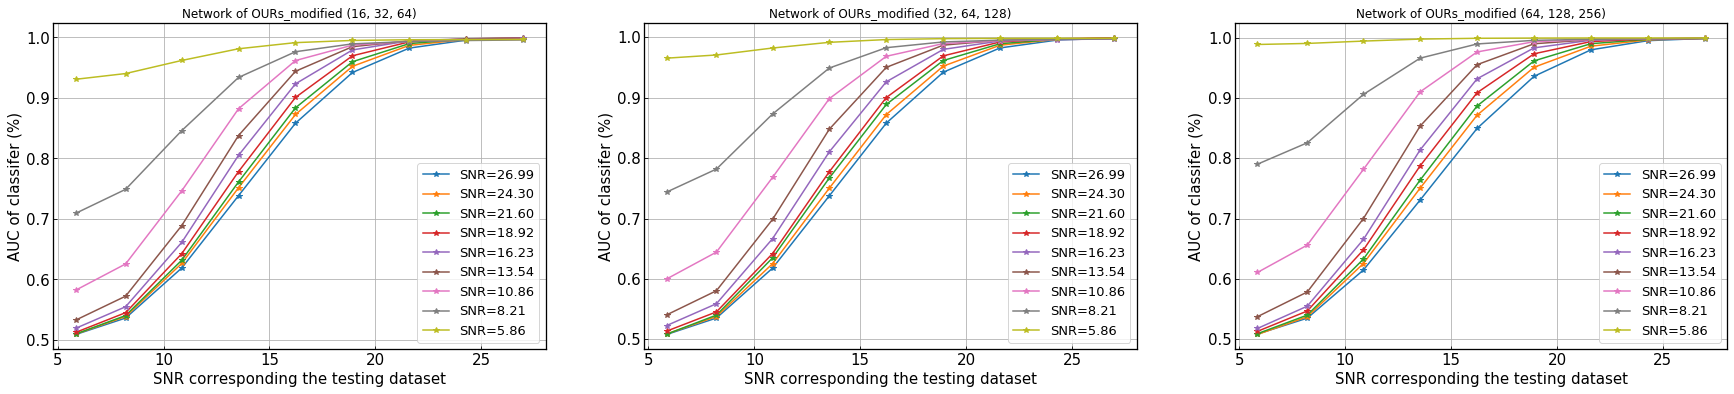

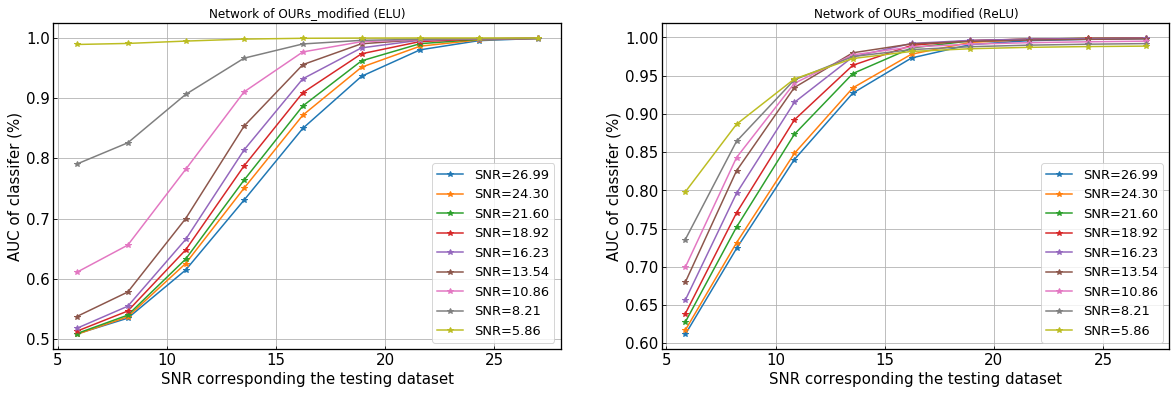

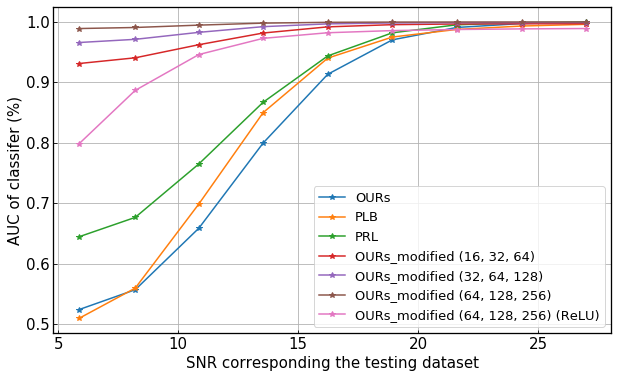

In [68]:
low = None # -2
SNR_list = [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]
SNR_list = [1, 0.8, 0.6, 0.5, 0.45, 0.4, 0.35, 0.3, 0.25,0.2, 0.15, 0.1, 0.05, 0.01][3:low]
SNR_MF_list = [53.97, 43.18, 32.39, 26.99, 24.30, 21.60, 18.92, 16.23, 13.54, 10.86, 8.21, 5.86, 4.77, 4.64][3:low]
# SNR_list = [0.5, 0.45, 0.4, 0.35, 0.3, 0.25,0.2, 0.15, 0.1, 0.05, 0.01]
# SNR_list = [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.45, 0.4, 0.35, 0.3, 0.25,0.2, 0.15, 0.1]
# SNR_MF_list = [54.12, 48.55, 43.27, 37.99, 32.31, 26.97, 21.62, 16.13, 10.87, 5.89]
index = ['SNR=%.2f' %snr for snr in SNR_MF_list]
snr_mf = np.load('./images/data/snr_mf_5fold.npy')
snr_mf_mean = snr_mf.mean(axis=1)

ACC_train_list = []
address = './AUC_data/'
for SNR_ in SNR_list:
    test_file = [add for add in os.listdir(address) if 'test_OURsSNR%s_accuracy_history' %int(SNR_*100) in add ][0]
    index_ = nd.load(address + test_file)[0].asnumpy().argmax()
    train_file = [add for add in os.listdir(address) if 'train_OURsSNR%s_accuracy_history' %int(SNR_*100) in add ][0]
    ACC_train_list.append(nd.load(address + train_file)[0].asnumpy()[index_])
# or
# ACC_train_list = np.load('./AUC_data/ACC_old_again.npy').tolist()
# ACC_train_list = [value[index] for index, value in enumerate(ACC_train_list)]

AUC_OURs = np.load('./AUC_data/AUC_OURs_old_newNoise_newSNRlist.npy').tolist()
AUC_PRL = np.load('./AUC_data/AUC_PRL_old_newNoise_newSNRlist.npy').tolist()
AUC_PLB = np.load('./AUC_data/AUC_PLB_old_newNoise_newSNRlist.npy').tolist()
AUC_OURs_modified_nf1 = np.load('./AUC_data/AUC_OURs_old_newNoise_OURs_modified1.npy').tolist()
AUC_OURs_modified_nf2 = np.load('./AUC_data/AUC_OURs_old_newNoise_OURs_modified2.npy').tolist()
AUC_OURs_modified_nf4 = np.load('./AUC_data/AUC_OURs_old_newNoise_OURs_modified4.npy').tolist()
AUC_OURs_modified_nf4_relu = np.load('./AUC_data/AUC_OURs_old_newNoise_OURs_modified4_relu.npy').tolist()



plt.figure(figsize=(10,6))
plt.plot(SNR_MF_list[::-1] ,ACC_train_list[::-1],'r-')
plt.grid()
plt.scatter(SNR_MF_list[::-1] ,ACC_train_list[::-1],marker='^', c='lime')
plt.xlabel('$SNR_{MF}$ of training data')
plt.ylabel('Accuracy')
# plt.legend(loc=4)
# plt.savefig('./images/AUC_OURs_oldnewNoise_localrandom_newSNRlist.pdf', dpi=300, bbox_inches='tight')
plt.show()



plt.figure(figsize=(10,6))
for i, SNR_ in enumerate(SNR_list):
    with sns.color_palette("Set1_r",len(SNR_list)):
        plt.plot(SNR_MF_list[::-1] ,AUC_OURs['%s' %int(SNR_*100)][3:][::-1][:low], '*-',label = index[i])
plt.grid()
plt.title('Network of OURs')
plt.xlabel('SNR corresponding the testing dataset')
plt.ylabel('AUC of classifer (%)')
plt.legend(loc=4)
plt.savefig('./images/AUC_OURs_oldnewNoise_localrandom_newSNRlist.pdf', dpi=300, bbox_inches='tight')
plt.show()



plt.figure(figsize=(10,6))
for i, SNR_ in enumerate(SNR_list):
    with sns.color_palette("Set1_r",len(SNR_list)):    
        plt.plot(SNR_MF_list[::-1] ,AUC_PRL['%s' %int(SNR_*100)][3:][::-1][:low] , '*-',label = index[i])
plt.grid()
plt.title('Network of PRL')
plt.xlabel('SNR corresponding the testing dataset')
plt.ylabel('AUC of classifer (%)')
plt.legend(loc=4)
plt.savefig('./images/AUC_PRL_oldnewNoise_localrandom_newSNRlist.pdf', dpi=300, bbox_inches='tight')
plt.show()


plt.figure(figsize=(10,6))
for i, SNR_ in enumerate(SNR_list):
    with sns.color_palette("Set1_r",len(SNR_list)):
        plt.plot(SNR_MF_list[::-1] ,AUC_PLB['%s' %int(SNR_*100)][3:][::-1][:low] , '*-',label = index[i])
plt.grid()
plt.xlabel('SNR corresponding the testing dataset')
plt.title('Network of PLB')
plt.ylabel('AUC of classifer (%)')
plt.legend(loc=4)
plt.savefig('./images/AUC_PLB_oldnewNoise_localrandom_newSNRlist.pdf', dpi=300, bbox_inches='tight')
plt.show()

SNR_list = [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]
SNR_list = [1, 0.8, 0.6, 0.5, 0.45, 0.4, 0.35, 0.3, 0.25,0.2, 0.15, 0.1, 0.05, 0.01][3:-2]
SNR_MF_list = [53.97, 43.18, 32.39, 26.99, 24.30, 21.60, 18.92, 16.23, 13.54, 10.86, 8.21, 5.86, 4.77, 4.64][3:-2]
# SNR_list = [0.5, 0.45, 0.4, 0.35, 0.3, 0.25,0.2, 0.15, 0.1, 0.05, 0.01]
# SNR_list = [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.45, 0.4, 0.35, 0.3, 0.25,0.2, 0.15, 0.1]
# SNR_MF_list = [54.12, 48.55, 43.27, 37.99, 32.31, 26.97, 21.62, 16.13, 10.87, 5.89]
index = ['SNR=%.2f' %snr for snr in SNR_MF_list]
snr_mf = np.load('./images/data/snr_mf_5fold.npy')
snr_mf_mean = snr_mf.mean(axis=1)
plt.figure(figsize=(30,6))
plt.subplot(1,3,1)
for i, SNR_ in enumerate(SNR_list):
    with sns.color_palette("Set1_r",len(SNR_list)):    
        plt.plot(SNR_MF_list[::-1] ,AUC_OURs_modified_nf1['%s' %int(SNR_*100)][::-1][:-2] , '*-',label = index[i])
plt.grid()
plt.xlabel('SNR corresponding the testing dataset')
plt.title('Network of OURs_modified '+'%s' %str((16*1,32*1,64*1)))
plt.ylabel('AUC of classifer (%)')
plt.legend(loc=4)
# plt.savefig('./images/AUC_PLB_old_localrandom_newNoise.pdf', dpi=300, bbox_inches='tight')
# plt.show()

# plt.figure(figsize=(10,6))
plt.subplot(1,3,2)
for i, SNR_ in enumerate(SNR_list):
    with sns.color_palette("Set1_r",len(SNR_list)):    
        plt.plot(SNR_MF_list[::-1] ,AUC_OURs_modified_nf2['%s' %int(SNR_*100)][::-1][:-2] , '*-',label = index[i])
plt.grid()
plt.xlabel('SNR corresponding the testing dataset')
plt.title('Network of OURs_modified '+'%s' %str((16*2,32*2,64*2)))
plt.ylabel('AUC of classifer (%)')
plt.legend(loc=4)
# plt.savefig('./images/AUC_PLB_old_localrandom_newNoise.pdf', dpi=300, bbox_inches='tight')
# plt.show()

# plt.figure(figsize=(10,6))
plt.subplot(1,3,3)
for i, SNR_ in enumerate(SNR_list):
    with sns.color_palette("Set1_r",len(SNR_list)):    
        plt.plot(SNR_MF_list[::-1] ,AUC_OURs_modified_nf4['%s' %int(SNR_*100)][::-1][:-2] , '*-',label = index[i])
plt.grid()
plt.xlabel('SNR corresponding the testing dataset')
plt.title('Network of OURs_modified '+'%s' %str((16*4,32*4,64*4)))
plt.ylabel('AUC of classifer (%)')
plt.legend(loc=4)
plt.savefig('./images/AUC_OURs_modified_nf_oldnewNoise_localrandom_newSNRlist.pdf', dpi=300, bbox_inches='tight')
plt.show()


plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
for i, SNR_ in enumerate(SNR_list):
    with sns.color_palette("Set1_r",len(SNR_list)):    
        plt.plot(SNR_MF_list[::-1] ,AUC_OURs_modified_nf4['%s' %int(SNR_*100)][::-1][:-2] , '*-',label = index[i])
plt.grid()
plt.xlabel('SNR corresponding the testing dataset')
plt.title('Network of OURs_modified (ELU)')
plt.ylabel('AUC of classifer (%)')
plt.legend(loc=4)
# plt.savefig('./images/AUC_PLB_old_localrandom_newNoise.pdf', dpi=300, bbox_inches='tight')
# plt.show()


plt.subplot(1,2,2)
for i, SNR_ in enumerate(SNR_list):
    with sns.color_palette("Set1_r",len(SNR_list)):    
        plt.plot(SNR_MF_list[::-1] ,AUC_OURs_modified_nf4_relu['%s' %int(SNR_*100)][::-1] , '*-',label = index[i])
plt.grid()
plt.xlabel('SNR corresponding the testing dataset')
plt.title('Network of OURs_modified (ReLU)')
plt.ylabel('AUC of classifer (%)')
plt.legend(loc=4)
plt.savefig('./images/AUC_OURs_modified_acc_oldnewNoise_localrandom_newSNRlist.pdf', dpi=300, bbox_inches='tight')
plt.show()

for i, SNR_ in enumerate(SNR_list[::-1]):
    plt.figure(figsize=(10,6))
    plt.plot(SNR_MF_list[::-1] ,AUC_OURs['%s' %int(SNR_*100)][3:][::-1][:-2], '*-',label = 'OURs')
    plt.plot(SNR_MF_list[::-1] ,AUC_PLB['%s' %int(SNR_*100)][3:][::-1][:-2] , '*-',label = 'PLB')
    plt.plot(SNR_MF_list[::-1] ,AUC_PRL['%s' %int(SNR_*100)][3:][::-1][:-2] , '*-',label = 'PRL')
    plt.plot(SNR_MF_list[::-1] ,AUC_OURs_modified_nf1['%s' %int(SNR_*100)][::-1][:-2] , '*-',label = 'OURs_modified '+'%s' %str((16*1,32*1,64*1)))
    plt.plot(SNR_MF_list[::-1] ,AUC_OURs_modified_nf2['%s' %int(SNR_*100)][::-1][:-2] , '*-',label = 'OURs_modified '+'%s' %str((16*2,32*2,64*2)))
    plt.plot(SNR_MF_list[::-1] ,AUC_OURs_modified_nf4['%s' %int(SNR_*100)][::-1][:-2] , '*-',label = 'OURs_modified '+'%s' %str((16*4,32*4,64*4)))
    plt.plot(SNR_MF_list[::-1] ,AUC_OURs_modified_nf4_relu['%s' %int(SNR_*100)][::-1] , '*-',label = 'OURs_modified '+'%s (ReLU)' %str((16*4,32*4,64*4)))
    plt.grid()
    plt.xlabel('SNR corresponding the testing dataset')
    plt.ylabel('AUC of classifer (%)')
    plt.legend(loc=4)
    plt.savefig('./images/AUC_models_oldnewNoise_newSNRlist.pdf', dpi=300, bbox_inches='tight')
    plt.show()
    break

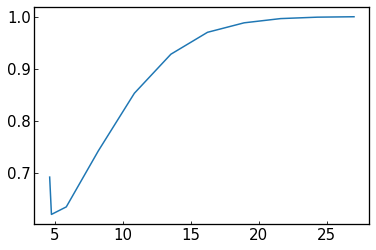

In [51]:
# plt.plot(fpr_old_again[10][10])
ACC = np.load('./AUC_data/ACC_old_again.npy').tolist()

11

Automatically created module for IPython interactive environment
Save or not? (y/n)n


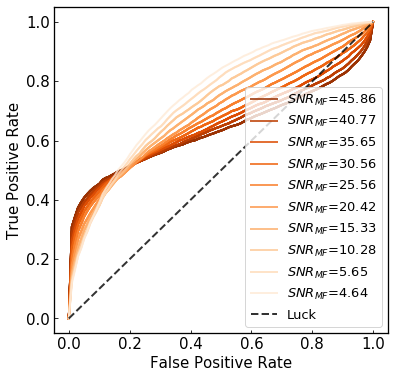

In [47]:
# https://stackoverflow.com/questions/41806066/families-of-curves-with-different-seaborn-palettes-in-one-plot
print(__doc__)
tpr_old_again = np.load('./AUC_data/tpr_old_again.npy').tolist()
fpr_old_again = np.load('./AUC_data/fpr_old_again.npy').tolist()

low = None
SNR_list = [1, 0.8, 0.6, 0.5, 0.45, 0.4, 0.35, 0.3, 0.25,0.2, 0.15, 0.1, 0.05, 0.01][3:low]
SNR_MF_list = [53.97, 43.18, 32.39, 26.99, 24.30, 21.60, 18.92, 16.23, 13.54, 10.86, 8.21, 5.86, 4.77, 4.64][3:low]
# SNR_list = [0.5, 0.45, 0.4, 0.35, 0.3, 0.25,0.2, 0.15, 0.1, 0.05, 0.01]
# SNR_list = [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.45, 0.4, 0.35, 0.3, 0.25,0.2, 0.15, 0.1]
# SNR_MF_list = [54.12, 48.55, 43.27, 37.99, 32.31, 26.97, 21.62, 16.13, 10.87, 5.89]
index = ['SNR=%.2f' %snr for snr in SNR_MF_list]
snr_mf = np.load('./images/data/snr_mf_5fold.npy')
snr_mf_mean = snr_mf.mean(axis=1)[::-1]

from scipy import interp
mean_fpr = np.linspace(0, 1, 100)
snr_training = 10
snr_testings = 10


# plt.figure(figsize=(10,10))
fig, ax = plt.subplots()
fig.set_figheight(6)
fig.set_figwidth(6)
mean_tpr_list = []
index_list = []
for snr_testing in range(0,snr_testings):
    tprs = []
#     for i in range(5):
    tprs.append(interp(mean_fpr
               ,fpr_old_again[snr_training][snr_testing]
               ,tpr_old_again[snr_training][snr_testing]).tolist())
    tprs[-1][0] = 0.0
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_tpr_list.append(mean_tpr.tolist())
    index_list.append('%s' %['$SNR_{MF}$=%.2f' %snr for snr in snr_mf_mean[2::2]][snr_testing])
#     plt.plot(mean_fpr, mean_tpr, lw=2, alpha=.8,
#              label = '%s' %['$SNR_{MF}$=%.2f' %snr for snr in snr_mf_mean[2::2]][snr_testing])
    df = pd.DataFrame(mean_tpr_list, index = index_list)
    df.T.plot(x=mean_fpr, ax=ax, color=sns.color_palette('Oranges_r', snr_testings), lw=2, alpha=.8)
    
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
#     ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2)

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k',
         label='Luck', alpha=.8)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# plt.title('Receiver operating characteristic example')
plt.legend(ncol = 1, loc="lower right")

if input('Save or not? (y/n)') == 'y':
    save_address = './images/'
    plt.savefig(save_address + 'ROC_comparison_training.eps', dpi = 300, bbox_inches = 'tight')
    plt.savefig(save_address + 'ROC_comparison_training.pdf', dpi = 300, bbox_inches = 'tight')
    print('Saved in '+save_address+'ROC_comparison_training.eps')
else:
    pass

plt.show()

In [17]:
AUC

[[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
 [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
 [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
 [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
 [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
 [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
 [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
 [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
 [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
 [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
 [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]]

In [16]:
ACC = np.load('./AUC_data/ACC_OURs_old_newNoise.npy')
AUC = np.load('./AUC_data/AUC_OURs_old_newNoise_training.npy').tolist()
AUC = np.load('./AUC_data/AUC_OURs_old_newNoise_testing.npy').tolist()

low = None # -2
SNR_list = [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]
SNR_list = [1, 0.8, 0.6, 0.5, 0.45, 0.4, 0.35, 0.3, 0.25,0.2, 0.15, 0.1, 0.05, 0.01][3:low]
SNR_MF_list = [53.97, 43.18, 32.39, 26.99, 24.30, 21.60, 18.92, 16.23, 13.54, 10.86, 8.21, 5.86, 4.77, 4.64][3:low]
# SNR_list = [0.5, 0.45, 0.4, 0.35, 0.3, 0.25,0.2, 0.15, 0.1, 0.05, 0.01]
# SNR_list = [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.45, 0.4, 0.35, 0.3, 0.25,0.2, 0.15, 0.1]
# SNR_MF_list = [54.12, 48.55, 43.27, 37.99, 32.31, 26.97, 21.62, 16.13, 10.87, 5.89]
index = ['SNR=%.2f' %snr for snr in SNR_MF_list]
snr_mf = np.load('./images/data/snr_mf_5fold.npy')
snr_mf_mean = snr_mf.mean(axis=1)


plt.figure(figsize=(10,6))
for i, SNR_ in enumerate(SNR_list):
    with sns.color_palette("Set1_r",len(SNR_list)):
        plt.plot(SNR_MF_list[::-1] ,AUC['%s' %int(SNR_*100)][3:][::-1][:low], '*-',label = index[i])
plt.grid()
plt.title('Network of OURs')
plt.xlabel('SNR corresponding the testing dataset')
plt.ylabel('AUC of classifer (%)')
plt.legend(loc=4)
# plt.savefig('./images/AUC_OURs_oldnewNoise_localrandom_newSNRlist.pdf', dpi=300, bbox_inches='tight')
plt.show()

TypeError: list indices must be integers or slices, not str

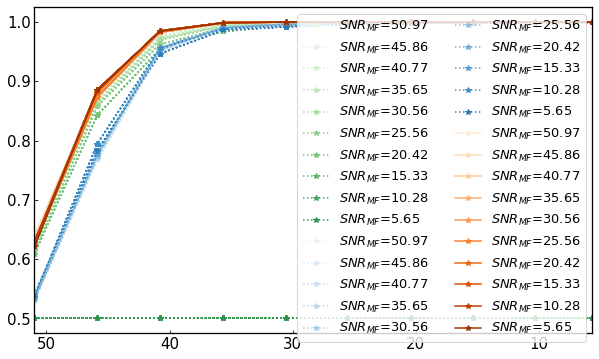

In [55]:
AUC_PRL = np.load('./AUC_data/AUC_PRL_new2.npy')
AUC_PLB = np.load('./AUC_data/AUC_PLB_new2.npy')
AUC_PLB = AUC_PLB[:,1::2,:][:,::-1,:]
AUC_OURs = np.load('./AUC_data/AUC_OURs_new2.npy')
AUC_OURs_modified = np.load('./AUC_data/AUC_OURs_modified.npy')
# AUC_OURs_2localnoise1 = np.load('./AUC_data/AUC_OURs_2localnoise1.npy')
# AUC_OURs_2localnoise5 = np.load('./AUC_data/AUC_OURs_2localnoise5.npy')
# AUC_OURs_2localnoise10 = np.load('./AUC_data/AUC_OURs_2localnoise10.npy')
# AUC_OURs_new3_localnoise = np.load('./AUC_data/AUC_OURs_new3_localnoise.npy')

# https://stackoverflow.com/questions/41806066/families-of-curves-with-different-seaborn-palettes-in-one-plot
snr_mf = np.load('./images/data/snr_mf_5fold.npy')
snr_mf_mean = snr_mf.mean(axis=1)

fig, ax = plt.subplots()
fig.set_figheight(6)
fig.set_figwidth(10)



df = pd.DataFrame(AUC_PRL.mean(axis=2), index = ['$SNR_{MF}$=%.2f' %snr for snr in snr_mf_mean[2::2]][::-1], columns=snr_mf_mean[2::2][::-1])
for i in range(AUC_PRL.shape[0]):
    df.T.plot(marker= '*',linestyle=':', ax=ax, color=sns.color_palette('Greens', 13), alpha = 1)    
    
df = pd.DataFrame(AUC_PLB.mean(axis=2), index = ['$SNR_{MF}$=%.2f' %snr for snr in snr_mf_mean[2::2]][::-1], columns=snr_mf_mean[2::2][::-1])
for i in range(AUC_PLB.shape[0]):
    df.T.plot(marker= '*',linestyle=':', ax=ax, color=sns.color_palette('Blues', 13), alpha = 1)    

df = pd.DataFrame(AUC_OURs.mean(axis=2), index = ['$SNR_{MF}$=%.2f' %snr for snr in snr_mf_mean[2::2]][::-1], columns=snr_mf_mean[2::2][::-1])    
for i in range(AUC_OURs.shape[0]):
    df.T.plot(marker= '*', ax=ax, color=sns.color_palette("Oranges", 10), alpha = 1)

ax.legend(ncol=2, loc='best')
# ax.set_xlim(0.09, 1.01)
# ax.set_ylabel('AUC of classifier (%)')
# ax.set_xlabel('SNR corresponding the testing dataset')
# ax.grid()
# if input('Save or not? (y/n)') == 'y':
#     save_address = './images/'
#     plt.savefig(save_address + 'AUC_comparison_training.eps', dpi = 300, bbox_inches = 'tight')
#     plt.savefig(save_address + 'AUC_comparison_training.pdf', dpi = 300, bbox_inches = 'tight')
#     print('Saved in '+save_address+'AUC_comparison_training.eps')
# else:
#     pass
plt.show()

In [50]:
snr_mf = np.load('./images/data/snr_mf_5fold.npy')
snr_mf_mean = snr_mf.mean(axis=1)

In [54]:
snr_mf_mean

array([  4.63982857,   4.74113166,   5.65292862,   7.77442809,
        10.28243198,  12.8157135 ,  15.33320026,  17.88634635,
        20.41547708,  22.97701746,  25.55851639,  28.08865864,
        30.55795145,  33.20315601,  35.64628161,  38.25031812,
        40.76856555,  43.3313526 ,  45.85824238,  48.35261292,  50.97136133])

In [43]:
from models.ConvNet import *

In [212]:
pool = 16
nf = 4
ConvNet(conv_params = {'kernel': ((1,16), (1,8), (1,8),), 
                                    'num_filter': (int(16*nf), int(32*nf), int(64*nf),),
                                    'stride': ((1,1), (1,1), (1,1),),
                                    'padding': ((0,0), (0,0), (0,0),),
                                    'dilate': ((1,3), (1,3), (1,3),)},
                        act_params = {'act_type': ('relu', 'relu', 'relu','relu',)},
                        pool_params = {'pool_type': ('avg', 'avg', 'avg',),
                                    'kernel': ((1,pool), (1,pool), (1,pool),),
                                    'stride': ((1,2), (1,2), (1,2),),
                                    'padding': ((0,0),(0,0), (0,0)),
                                    'dilate': ((1,1), (1,1), (1,1),)},
                        fc_params = {'hidden_dim': (128,)}, drop_prob = 0.75, 
#                         input_dim = (2,1,8192)
                        input_dim = (1,1,8192)
                    )

W1 (64, 1, 1, 16) b1 (64,)
W2 (128, 64, 1, 8) b2 (128,)
W3 (256, 128, 1, 8) b3 (256,)
W4 (253440, 128) b4 (128,)
W5 (128, 2) b5 (2,)
------------
Weight dims: 3.276928e+07
Bias dims: 5.780000e+02
------------
